In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go


import ternary
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.interpolate import NearestNDInterpolator

from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances

%matplotlib inline


# Plotting Functions

In [65]:
def generate_mesh(I_range, Br_range, Cl_range):
    """
    Generate a mesh of points for I, Br, and Cl that sum to 1.

    :param I_range: Tuple of (start, end, step) for I.
    :param Br_range: Tuple of (start, end, step) for Br.
    :param Cl_range: Tuple of (start, end, step) for Cl.
    :return: List of [I, Br, Cl] points that sum to 1.
    """
    mesh = []
    I_start, I_end, I_step = I_range
    Br_start, Br_end, Br_step = Br_range
    Cl_start, Cl_end, Cl_step = Cl_range

    I_values = np.linspace(I_start, I_end, round((I_end - I_start) / I_step) + 1)
    Br_values = np.linspace(Br_start, Br_end, round((Br_end - Br_start) / Br_step) + 1)
    Cl_values = np.linspace(Cl_start, Cl_end, round((Cl_end - Cl_start) / Cl_step) + 1)

    for i in I_values:
        for br in Br_values:
            for cl in Cl_values:
                if abs(br + cl + i - 1) < 1e-4:  # Add a small tolerance to deal with floating point precision
                    mesh.append([i, br, cl])

    return mesh



def make_targets(MA_values, mesh_array):
    # Create solutions
    targets = []
    for MA in MA_values:
        for i, br, cl in mesh_array:
            targets.append(make_solution(MA, i, cl))
    return targets


def plot_mesh(mesh_array, color='red', color_values=None, single_point=None, fig=None, symbol='circle', size=5, **marker_kwargs):
    if fig is None:
        fig = go.Figure()

    # Prepare hover text
    hover_text = [f'Color value: {val}' for val in color_values] if color_values is not None else None

    fig.add_trace(go.Scatterternary(
        a=mesh_array[:, 1], b=mesh_array[:, 0], c=mesh_array[:, 2],
        mode='markers',
        marker=dict(color=color_values if color_values is not None else color, size=size, 
                    colorscale='Viridis' if color_values is not None else None, 
                    colorbar=dict(title='Colorbar') if color_values is not None else None, 
                    symbol=symbol, **marker_kwargs),
        text=hover_text  # Add hover text
    ))

    if single_point is not None:
        fig.add_trace(go.Scatterternary(
            a=[single_point[1]], b=[single_point[0]], c=[single_point[2]],
            mode='markers',
            marker=dict(color='red', size=size, symbol=symbol),
            name='Single Point'
        ))

    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")
    fig.update_ternaries(sum=1, baxis_min=.8)
    fig.update_layout({
        'plot_bgcolor': 'white',
        'paper_bgcolor': 'white',
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig


def plot_mesh_avg(mesh_array, color='red', color_values=None, single_point=None, fig=None, symbol='circle', size=5, **marker_kwargs):
    if fig is None:
        fig = go.Figure()

    df_mesh = pd.DataFrame(mesh_array, columns=['I', 'Br', 'Cl'])
    if color_values is not None:
        df_mesh['color_values'] = color_values
        df_mesh['compstring'] = df_mesh[['I', 'Br', 'Cl']].astype(str).agg('-'.join, axis=1)
        # Group by 'I', 'Br', 'Cl'
        grouped = df_mesh.groupby(['compstring'])

        df_grouped = grouped.agg(lambda x: x.mean() if len(x) > 1 else x.iloc[0])
        df_grouped.reset_index(inplace=True)
        marker_color = df_grouped['color_values']
    else:
        df_grouped = df_mesh
        marker_color = color


    hover_text = [f'Color value: {val}' for val in df_grouped['color_values']] if color_values is not None else None

    fig.add_trace(go.Scatterternary(
        a=df_grouped['Br'],
        b=df_grouped['I'],
        c=df_grouped['Cl'],
        mode='markers',
        marker=dict(color=marker_color, size=size, symbol=symbol, 
                    colorscale='Viridis' if color_values is not None else None, 
                    colorbar=dict(title='Colorbar') if color_values is not None else None, 
                    **marker_kwargs),
        text=hover_text  =
    ))

    if single_point is not None:
        fig.add_trace(go.Scatterternary(
            a=[single_point[1]], b=[single_point[0]], c=[single_point[2]],
            mode='markers',
            marker=dict(color='red', size=size, symbol=symbol),
            name='Single Point'
        ))

    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")
    fig.update_ternaries(sum=1, baxis_min=.8)
    fig.update_layout({
        'plot_bgcolor': 'white',
        'paper_bgcolor': 'white',
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig


def plot_BO_mesh(mesh_array, acq_values, fig=None, symbol='circle', **marker_kwargs):

    if fig is None:
        fig = go.Figure()


    fig.add_trace(go.Scatterternary(a=mesh_array[:, 1], b=mesh_array[:, 0], c=mesh_array[:, 2], mode='markers', 
                                    marker=dict(color=acq_values, colorscale='Viridis', symbol=symbol, **marker_kwargs)))


    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")


    fig.update_ternaries(sum=1, baxis_min=.8)  # update for I axis


    fig.update_layout({
        'plot_bgcolor': 'white', 
        'paper_bgcolor': 'white',  
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig  


def enforce_minimum_distance(ax_client, num_trials, min_distance):
    new_points = []
    trial_indices = []
    while len(new_points) < num_trials:

        batch_trial_indices, _ = ax_client.get_next_trials(1)
        if not batch_trial_indices:
            break
        for trial_index in batch_trial_indices:
            trial = ax_client.get_trial(trial_index)
            point = trial.arm.parameters
            point_vector = np.array(list(point.values()))  # Convert the point to a vector
            # Check if the point is far enough from all existing points
            if all(np.linalg.norm(point_vector - np.array(list(existing_point.values()))) >= min_distance for existing_point in new_points):
                new_points.append(point)
                trial_indices.append(trial_index)
    return trial_indices


def create_experiment(ax_client, search_parameters, objectives, parameter_constraints):
    ax_client.create_experiment(
        name="moo_experiment",
        parameters=search_parameters,
        objectives=objectives,
        parameter_constraints=parameter_constraints,
        overwrite_existing_experiment=True,
    )

def complete_trials(ax_client, df, standard_errors):
    for _, row in df.iterrows():
        metrics_data = {}
        for metric, standard_error in standard_errors.items():
            if pd.notnull(row[metric]):
                metrics_data[metric] = (row[metric], standard_error)
        if metrics_data:
            trial_parameters = {'I': row['I'], 'Br': row['Br']}
            _, trial_index = ax_client.attach_trial(trial_parameters)
            ax_client.complete_trial(trial_index=trial_index, raw_data=metrics_data)

def create_suggested_samples_df(ax_client, batch_trial_indices):
    suggested_samples = []
    for trial_index in batch_trial_indices:
        trial = ax_client.get_trial(trial_index)
        arm_parameters = trial.arm.parameters
        suggested_samples.append(arm_parameters)
    df_suggested = pd.DataFrame(suggested_samples)
    df_suggested['I'] = df_suggested['I'].round(8)
    df_suggested['Br'] = df_suggested['Br'].round(8)
    df_suggested['Cl'] = 1 - df_suggested['I'] - df_suggested['Br']
    df_suggested.loc[np.isclose(df_suggested['I'] + df_suggested['Br'], 1, atol=1e-8), 'Cl'] = 0
    return df_suggested

def evaluate_acquisition_function(ax_client, search_parameters, metrics, weights):
    model = ax_client.generation_strategy.model
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], 101)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], 101)
    acq_values = np.zeros((len(x_eval), len(y_eval)))
    metric_names = [metric.name for metric in metrics]
    for i, x in enumerate(x_eval):
        for j, y in enumerate(y_eval):
            if x + y >= 0.95 and x + y <= 1:
                plot_parameters = [ObservationFeatures(parameters={'I': x, 'Br': y})]
                acq_values_dict, _ = model.predict(plot_parameters)
                scalarized_acq_value = 0
                for metric_name, weight in zip(metric_names, weights):
                    acq_value = acq_values_dict[metric_name][0]
                    scalarized_acq_value += weight * acq_value
                acq_values[i, j] = scalarized_acq_value
            else:
                acq_values[i, j] = np.nan
    return acq_values

def get_batch_trial_indices(ax_client, num_trials, min_distance=None):
    if min_distance is not None:
        return enforce_minimum_distance(ax_client, num_trials=num_trials, min_distance=min_distance)
    else:
        trial_indices, _ = ax_client.get_next_trials(num_trials)
        return trial_indices
    
    
def create_mesh_array(search_parameters, num_points=101):
    """
    Create a mesh array from the evaluation points.
    
    Args:
        search_parameters (list[dict]): The search parameters.
        num_points (int, optional): The number of points to evaluate. Defaults to 101.
    
    Returns:
        np.ndarray: The mesh array.
    """
    # Define points at which we'll evaluate the acquisition function
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], num_points)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], num_points)

    # Create a mesh array from the evaluation points
    mesh_array = np.zeros((len(x_eval), len(y_eval), 3))
    mesh_array[:, :, 0] = x_eval[:, None]
    mesh_array[:, :, 1] = y_eval[None, :]
    mesh_array[:, :, 2] = 1 - x_eval[:, None] - y_eval[None, :]

    return mesh_array


def flatten_mesh_array(mesh_array):
    return mesh_array.reshape(-1, 3), acq_values.flatten()

def plot_acquisition_function(mesh_array_flat, acq_values_flat):
    fig = plot_BO_mesh(mesh_array_flat, acq_values_flat)
    return fig

def plot_data_points(df, df_suggested, fig):
    mesh_array_0 = df[['I', 'Br', 'Cl']].values
    mesh_array_1 = df_suggested[['I', 'Br', 'Cl']].values
    fig = plot_mesh(mesh_array_0, color_values = 'black', fig=fig, size=2)
    fig = plot_mesh(mesh_array_1, color='red',symbol = 'x', fig=fig, size = 5)
    return fig


def complete_trials_and_get_new_df(ax_client, batch_trial_indices, df):
    new_rows = []
    for trial_index in batch_trial_indices:
        trial = ax_client.get_trial(trial_index)
        parameters = trial.arm.parameters
        metric_value = np.random.uniform(low=0.1, high=.5, size=(1,))[0]  # TODO: replace with actual function
        ax_client.complete_trial(trial_index=trial_index, raw_data={'emission_energy_difference': (metric_value, 0.0)})
        parameters['emission_energy_difference'] = metric_value  # store the metric value in the parameters
        new_rows.append(parameters)

    # Append the new rows to the original DataFrame, which will then be fed back into Ax for the next batch
    df_new = pd.DataFrame(new_rows)
    df_new = pd.concat([df, df_new], ignore_index=True)
    df_new['Cl'] = 1 - df_new['I'] - df_new['Br']  # calculate Cl from I and B

    # If I + Br is close to 1 within a tolerance, set Cl to exactly 0
    df_new.loc[np.isclose(df_new['I'] + df_new['Br'], 1, atol=1e-8), 'Cl'] = 0

    return df_new


SyntaxError: invalid syntax (1676339721.py, line 109)

In [66]:
import ternary
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.interpolate import NearestNDInterpolator
df = pd.DataFrame()
def ternary_heatmap(cols, lims, response, responselabel = None, markerfilter = None, gpr=False, func=np.nanmean, log=False, df=df, colorbar = True, ax=None, label_axes = ['l', 'r', 'b'], **kwargs):
    if responselabel is None:
        responselabel = response
    xraw = df[cols].values
    yraw = df[response].values
    if markerfilter is None:
        mfraw = np.array([True for i in range(xraw.shape[0])])
    else:
        mfraw = df[markerfilter].values
            
    if log:
        yraw = np.log(yraw)
    x = []
    y = []
    mf = []
    for ux in np.unique(xraw, axis=0):
        idx = (xraw == ux).all(axis=1)
        yval = func(yraw[idx])
        
        if not np.isnan(yval):
            y.append(yval)
            x.append(ux)
            mf.append(np.product(mfraw[idx], dtype = bool))
            
    mf = np.array(mf)
#     print(mf)
    # return x
    x = np.array(x)
    # return x
    # x = xraw[idx]
    # y = y[idx]
    x[:,0] = (x[:,0] - lims[0][0])/(lims[0][1] - lims[0][0])
    x[:,1] = (x[:,1] - lims[1][0])/(lims[1][1] - lims[1][0])
    x[:,2] = (x[:,2] - lims[2][0])/(lims[2][1] - lims[2][0])
    interpolator = NearestNDInterpolator(x,y)
    def f(x):
        return interpolator(x)[0] 
    
    ## Boundary and Gridlines
    scale = 40
    if ax is None:
        fig,ax=plt.subplots(figsize=(5,4))
    figure, tax = ternary.figure(ax=ax, scale=scale)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=0.5)
    tax.gridlines(color="black", multiple=0.2*scale)
    # tax.gridlines(color="blue", multiple=1, linewidth=0.5)

    # Set Axis labels and Title
    fontsize = 20
    # tax.set_title("Simplex Boundary and Gridlines", fontsize=fontsize)
    
    if "l" in label_axes:
#         tax.left_axis_label(cols[2]+'\n', fontsize=18)
        tax.left_corner_label(cols[2], fontsize=20)
    if "b" in label_axes:
#         tax.bottom_axis_label(cols[0]+'\n', fontsize=20)
        tax.right_corner_label(cols[0], fontsize=20)
    if "r" in label_axes:
#         tax.right_axis_label(cols[1]+'\n', fontsize=20)
        tax.top_corner_label(cols[1], fontsize=20)


    

    ticks = [0.2,0.4,0.6,0.8]

    for axis, (lmin, lmax) in zip(['b', 'r', 'l'], lims):
        ticklocs = [a*scale for a in ticks]
        if axis in label_axes:
            ticklabels = [lmin + a*(lmax-lmin) for a in ticks]
        else:
            ticklabels = ['' for a in ticks]
        tax.ticks(axis=axis, linewidth=0.1, ticks=ticklabels, locations=ticklocs, tick_formats='%.2f', offset=0.035)


    if log:
        response += ' (log)'
    if colorbar:
        tax.heatmapf(f, colorbar=True, scientific=False, cbarlabel=responselabel, **kwargs)
    else:
        tax.heatmapf(f, colorbar=False, scientific=False, **kwargs)

    
    idx = mf==True
    if sum(idx)>0:
        tax.scatter(x[mf]*scale, s=10, marker='o', c='k', zorder=10)
    idx = mf==False
    if sum(idx)>0:
        tax.scatter(x[~mf]*scale, s=30, marker='x', color=plt.cm.gray(0.5), zorder=10)


    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')

    return tax

In [67]:
# python version 3.10.11
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go


%config InlineBackend.figure_format = 'retina'
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['axes.linewidth'] = 1.75 

from ax.core.observation import ObservationFeatures
from ax.core.objective import ScalarizedObjective
from ax.core.optimization_config import OptimizationConfig
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge.factory import get_GPEI
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep




import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import pickle as pkl
import pandas as pd

from scipy.stats import norm
%config InlineBackend.figure_format = 'retina'
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally



from ax.core.observation import ObservationFeatures
from ax.core.objective import ScalarizedObjective
from ax.core.optimization_config import OptimizationConfig
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge.factory import get_GPEI
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep


from ax import *
from ax.core import ParameterType, RangeParameter, SearchSpace, OptimizationConfig#, ScalarizedObjective

import pandas as pd
import torch
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge import get_sobol
from ax.modelbridge.factory import get_GPEI
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.service.ax_client import AxClient
from botorch.acquisition import qNegIntegratedPosteriorVariance, qNoisyExpectedImprovement, qUpperConfidenceBound
from botorch.models import SingleTaskGP
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement, 
)
from botorch.models.gp_regression import FixedNoiseGP


# from botorch.acquisition import qUpperConfidenceBound
from botorch.acquisition.monte_carlo import qUpperConfidenceBound

from botorch.acquisition.input_constructors import acqf_input_constructor


def generate_mesh(I_range, Br_range, Cl_range):
    """
    Generate a mesh of points for I, Br, and Cl that sum to 1.

    :param I_range: Tuple of (start, end, step) for I.
    :param Br_range: Tuple of (start, end, step) for Br.
    :param Cl_range: Tuple of (start, end, step) for Cl.
    :return: List of [I, Br, Cl] points that sum to 1.
    """
    mesh = []
    I_start, I_end, I_step = I_range
    Br_start, Br_end, Br_step = Br_range
    Cl_start, Cl_end, Cl_step = Cl_range

    I_values = np.linspace(I_start, I_end, round((I_end - I_start) / I_step) + 1)
    Br_values = np.linspace(Br_start, Br_end, round((Br_end - Br_start) / Br_step) + 1)
    Cl_values = np.linspace(Cl_start, Cl_end, round((Cl_end - Cl_start) / Cl_step) + 1)

    for i in I_values:
        for br in Br_values:
            for cl in Cl_values:
                if abs(br + cl + i - 1) < 1e-4:  # Add a small tolerance to deal with floating point precision
                    mesh.append([i, br, cl])

    return mesh



def make_targets(MA_values, mesh_array):
    # Create solutions
    targets = []
    for MA in MA_values:
        for i, br, cl in mesh_array:
            targets.append(make_solution(MA, i, cl))
    return targets


def plot_mesh_ml(mesh_array, color='red', color_values=None, fig=None, symbol='circle', size =5, **marker_kwargs):
    # If no figure is provided, create a new one
    if fig is None:
        fig = go.Figure()


    if color_values is not None:
        marker_color = color_values
        colorscale = 'Viridis'  
        colorbar = dict(title = 'Colorbar')  
    else:
        marker_color = color
        colorscale = None
        colorbar = None


    fig.add_trace(go.Scatterternary(a=mesh_array[:, 1], b=mesh_array[:, 0], c=mesh_array[:, 2], mode='markers', 
                                    marker=dict(color=marker_color, size= size, colorscale=colorscale, colorbar=colorbar, symbol=symbol, **marker_kwargs)))


    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")


    fig.update_ternaries(sum=1, baxis_min=.8) 


    fig.update_layout({
        'plot_bgcolor': 'white', 
        'paper_bgcolor': 'white', 
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig  

def plot_mesh_avg(mesh_array, color='red', color_values=None, fig=None, symbol='circle', size=5, **marker_kwargs):

    if fig is None:
        fig = go.Figure()


    df_mesh = pd.DataFrame(mesh_array, columns=['I', 'Br', 'Cl'])
    if color_values is not None:
        df_mesh['color_values'] = color_values


    if color_values is not None:
        df_grouped = df_mesh.groupby(['I', 'Br', 'Cl'], as_index=False)['color_values'].mean()
        marker_color = df_grouped['color_values']
    else:
        df_grouped = df_mesh
        marker_color = color


    fig.add_trace(go.Scatterternary(
        a=df_grouped['Br'],
        b=df_grouped['I'],
        c=df_grouped['Cl'],
        mode='markers',
        marker=dict(
            color=marker_color,
            size=size,
            symbol=symbol,
            colorscale='Viridis' if color_values is not None else None,
            colorbar=dict(title='Colorbar') if color_values is not None else None,
            **marker_kwargs
        )
    ))


    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")


    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")


    fig.update_ternaries(sum=1, baxis_min=.8) 



    fig.update_layout({
        'plot_bgcolor': 'white',
        'paper_bgcolor': 'white',
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig  


def plot_BO_mesh(mesh_array, acq_values, fig=None, symbol='circle', **marker_kwargs):

    if fig is None:
        fig = go.Figure()


    fig.add_trace(go.Scatterternary(a=mesh_array[:, 1], b=mesh_array[:, 0], c=mesh_array[:, 2], mode='markers', 
                                    marker=dict(color=acq_values, colorscale='Viridis', symbol=symbol, **marker_kwargs)))


    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")


    fig.update_ternaries(sum=1, baxis_min=.8)

   
    fig.update_layout({
        'plot_bgcolor': 'white',
        'paper_bgcolor': 'white',
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig 



def enforce_minimum_distance(ax_client, num_trials, min_distance):
    new_points = []
    trial_indices = []
    while len(new_points) < num_trials:
       
        batch_trial_indices, _ = ax_client.get_next_trials(1)
        if not batch_trial_indices:
            break
        for trial_index in batch_trial_indices:
            trial = ax_client.get_trial(trial_index)
            point = trial.arm.parameters
            point_vector = np.array(list(point.values()))
           
            if all(np.linalg.norm(point_vector - np.array(list(existing_point.values()))) >= min_distance for existing_point in new_points):
                new_points.append(point)
                trial_indices.append(trial_index)
    return trial_indices


def create_experiment(ax_client, search_parameters, objectives, parameter_constraints):
    ax_client.create_experiment(
        name="moo_experiment",
        parameters=search_parameters,
        objectives=objectives,
        parameter_constraints=parameter_constraints,
        overwrite_existing_experiment=True,
    )

def complete_trials(ax_client, df, standard_errors):
    for _, row in df.iterrows():
        metrics_data = {}
        for metric, standard_error in standard_errors.items():
            if pd.notnull(row[metric]):
                metrics_data[metric] = (row[metric], standard_error)
        if metrics_data:
            trial_parameters = {'I': row['I'], 'Br': row['Br']}
            _, trial_index = ax_client.attach_trial(trial_parameters)
            ax_client.complete_trial(trial_index=trial_index, raw_data=metrics_data)

def create_suggested_samples_df(ax_client, batch_trial_indices):
    suggested_samples = []
    for trial_index in batch_trial_indices:
        trial = ax_client.get_trial(trial_index)
        arm_parameters = trial.arm.parameters
        suggested_samples.append(arm_parameters)
    df_suggested = pd.DataFrame(suggested_samples)
    df_suggested['I'] = df_suggested['I'].round(8)
    df_suggested['Br'] = df_suggested['Br'].round(8)
    df_suggested['Cl'] = 1 - df_suggested['I'] - df_suggested['Br']
    df_suggested.loc[np.isclose(df_suggested['I'] + df_suggested['Br'], 1, atol=1e-8), 'Cl'] = 0
    return df_suggested

def evaluate_acquisition_function(ax_client, search_parameters, metrics, weights):
    model = ax_client.generation_strategy.model
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], 101)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], 101)
    acq_values = np.zeros((len(x_eval), len(y_eval)))
    metric_names = [metric.name for metric in metrics]
    for i, x in enumerate(x_eval):
        for j, y in enumerate(y_eval):
            if x + y >= 0.95 and x + y <= 1:
                plot_parameters = [ObservationFeatures(parameters={'I': x, 'Br': y})]
                acq_values_dict, _ = model.predict(plot_parameters)
                scalarized_acq_value = 0
                for metric_name, weight in zip(metric_names, weights):
                    acq_value = acq_values_dict[metric_name][0]
                    scalarized_acq_value += weight * acq_value
                acq_values[i, j] = scalarized_acq_value
            else:
                acq_values[i, j] = np.nan
    return acq_values

def get_batch_trial_indices(ax_client, num_trials, min_distance=None):
    if min_distance is not None:
        return enforce_minimum_distance(ax_client, num_trials=num_trials, min_distance=min_distance)
    else:
        trial_indices, _ = ax_client.get_next_trials(num_trials)
        return trial_indices
    
    
def create_mesh_array(search_parameters, num_points=101):
    """
    Create a mesh array from the evaluation points.
    
    Args:
        search_parameters (list[dict]): The search parameters.
        num_points (int, optional): The number of points to evaluate. Defaults to 101.
    
    Returns:
        np.ndarray: The mesh array.
    """
    # Define points at which we'll evaluate the acquisition function
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], num_points)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], num_points)

    # Create a mesh array from the evaluation points
    mesh_array = np.zeros((len(x_eval), len(y_eval), 3))
    mesh_array[:, :, 0] = x_eval[:, None]
    mesh_array[:, :, 1] = y_eval[None, :]
    mesh_array[:, :, 2] = 1 - x_eval[:, None] - y_eval[None, :]

    return mesh_array


def flatten_mesh_array(mesh_array):
    return mesh_array.reshape(-1, 3), acq_values.flatten()

def plot_acquisition_function(mesh_array_flat, acq_values_flat):
    fig = plot_BO_mesh(mesh_array_flat, acq_values_flat)
    return fig

def plot_data_points(df, df_suggested, fig):
    mesh_array_0 = df[['I', 'Br', 'Cl']].values
    mesh_array_1 = df_suggested[['I', 'Br', 'Cl']].values
    fig = plot_mesh(mesh_array_0, color_values = 'black', fig=fig, size=5)
    fig = plot_mesh(mesh_array_1, color='red',symbol = 'star', fig=fig, size = 10)
    return fig


def complete_trials_and_get_new_df(ax_client, batch_trial_indices, df):
    new_rows = []
    for trial_index in batch_trial_indices:
        trial = ax_client.get_trial(trial_index)
        parameters = trial.arm.parameters
        metric_value = np.random.uniform(low=0.1, high=.5, size=(1,))[0]  # TODO: replace with actual function
        ax_client.complete_trial(trial_index=trial_index, raw_data={'emission_energy_difference': (metric_value, 0.0)})
        parameters['emission_energy_difference'] = metric_value  # store the metric value in the parameters
        new_rows.append(parameters)

    # Append the new rows to the original DataFrame, which will then be fed back into Ax for the next batch
    df_new = pd.DataFrame(new_rows)
    df_new = pd.concat([df, df_new], ignore_index=True)
    df_new['Cl'] = 1 - df_new['I'] - df_new['Br']  # calculate Cl from I and B

    # If I + Br is close to 1 within a tolerance, set Cl to exactly 0
    df_new.loc[np.isclose(df_new['I'] + df_new['Br'], 1, atol=1e-8), 'Cl'] = 0

    return df_new


# def enforce_minimum_distance(ax_client, num_trials, min_distance, max_attempts=100):
#     new_points = []
#     trial_indices = []
#     attempts = 0
#     while len(new_points) < num_trials and attempts < max_attempts:
#         # Get a batch of points from the optimizer
#         batch_trial_indices, _ = ax_client.get_next_trials(1)
#         if not batch_trial_indices:  # If no new trials were generated, break the loop
#             break
#         for trial_index in batch_trial_indices:
#             trial = ax_client.get_trial(trial_index)
#             point = trial.arm.parameters
#             point_vector = np.array(list(point.values()))  # Convert the point to a vector
#             # Check if the point is far enough from all existing points
#             if all(np.linalg.norm(point_vector - np.array(list(existing_point.values()))) >= min_distance for existing_point in new_points):
#                 new_points.append(point)
#                 trial_indices.append(trial_index)
#         attempts += 1
#     return trial_indices



In [68]:
def plot_three_prePS(response, df,  **kwargs):
    fig, ax = plt.subplots(1,3,figsize=(10.5,3))
    for ax_, MA, label_axes, cb in zip(
        ax, 
        [0, 0.05, 0.1], 
        [["l", "b"], [], ["r"]],
        [False, False, False],
    ):
        dfsel = df[df['MA'] == MA]
        
        tax = ternary_heatmap(
            ['Cl', 'Br', 'I'],
            [
                (0,0.2),
                (0, 0.2),
                (0.8, 1.0)
            ],
            response,
            func=np.nanmean,
            gpr=False,
            ax=ax_,
            df=dfsel,
            label_axes=label_axes,
            colorbar=False,
            **kwargs
            )
#         ax_[0].set_title(f'MA = {MA}')
    return fig, ax

In [69]:
def plot_three_error(response, df, **kwargs):
    fig, ax = plt.subplots(2,3,figsize=(12.5,6))
    for ax_, MA in zip(ax.T, [0, 0.05, 0.1]):
        dfsel = df[df['MA'] == MA]
        

        tax = ternary_heatmap(
            ['Cl', 'Br', 'I'],
            [
                (0,0.2),
                (0, 0.2),
                (0.8, 1.0)
            ],
            response,
            func=np.nanmean,
            gpr=False,
            ax=ax_[0],
            df=dfsel,
            **kwargs
            )

        tax = ternary_heatmap(
            ['Cl', 'Br', 'I'],
            [
                (0,0.2),
                (0, 0.2),
                (0.8, 1.0)
            ],
            response,
            cmap=plt.cm.viridis,
            func=np.nanstd,
            gpr=False,

            df=dfsel,
            ax=ax_[1]
            )


In [70]:
def plot_three(response, df,  a=(0,.20), b=(0,.20), c=(.80,1.00),**kwargs ):
    fig, ax = plt.subplots(1,3,figsize=(12.5,3))
    for ax_, MA in zip(ax, [0, 0.05, 0.1]):
        dfsel = df[df['MA'] == MA]
        
        tax = ternary_heatmap(
            ['Cl', 'Br', 'I'],
            [
                a,
                b,
                c
            ],
            response,
            func=np.nanmean,
            gpr=False,
            ax=ax_,
            df=dfsel,
            **kwargs
            )
        fig.show()
    return fig, ax
#         ax_[0].set_title(f'MA = {MA}')

In [71]:
def plot_three_prePS(response, df,  **kwargs):
    fig, ax = plt.subplots(1,3,figsize=(10.5,3))
    for ax_, MA, label_axes, cb in zip(
        ax, 
        [0, 0.05, 0.1], 
        [["l", "b"], [], ["r"]],
        [False, False, False],
    ):
        dfsel = df[df['MA'] == MA]
        
        tax = ternary_heatmap(
            ['Cl', 'Br', 'I'],
            [
                (0,0.2),
                (0, 0.2),
                (0.8, 1.0)
            ],
            response,
            func=np.nanmean,
            gpr=False,
            ax=ax_,
            df=dfsel,
            label_axes=label_axes,
            colorbar=False,
            **kwargs
            )
#         ax_[0].set_title(f'MA = {MA}')
    return fig, ax

# Load + Merge Datasets

In [72]:
def compstring(r):
    return f"{r['MA']:.3f}_{r['I']:.3f}_{r['Br']:.3f}_{r['Cl']:.3f}"

Film fabrication results

In [73]:
allfilmdf = pd.read_csv(
    "20220307 All WBG Films No Filter.csv",
    
    index_col = 0
)
for k in ["MA", "I", "Br", "Cl"]:
    allfilmdf[k] = np.round(allfilmdf[k], 3)

In [74]:
print(allfilmdf.shape)
allfilmdf.columns

(191, 33)


Index(['name', 'storage_slot', 'batch', 'MA', 'I', 'Br', 'Cl', 'spincoat_time',
       'redplspec_intensity', 'redplspec_peakev', 'redplspec_fwhm',
       'photostability_intensity_rate', 'photostability_intensity_scale',
       'photostability_intensity_normdelta', 'photostability_peakev_rate',
       'photostability_peakev_scale', 'photostability_peakev_delta',
       'photostability_peakev_delta1', 'bandgap', 'emission_energy', 't600',
       'experimentid', 'storage_tray', 'spincoat0_drop0_solutes', 'darkfield',
       'brightfield', 'plimage', 'redplspec', 'redplspec_fit', 'transmission',
       'absorbance', 'missing_characterization', 'order'],
      dtype='object')

In [75]:
allfilmdf = allfilmdf[["MA", "I", "Br", "Cl", "name", "redplspec_intensity", 'redplspec_peakev', 'redplspec_fwhm',
       'photostability_intensity_rate', 'photostability_intensity_scale',
       'photostability_intensity_normdelta', 'photostability_peakev_rate',
       'photostability_peakev_scale', 'photostability_peakev_delta',
       'photostability_peakev_delta1',
       'experimentid']]
allfilmdf["compstring"] = allfilmdf.apply(compstring, axis=1)
allfilmdf = allfilmdf[~allfilmdf["photostability_intensity_rate"].isna()] #missing data for some samples

print(allfilmdf.shape)
allfilmdf.columns

(155, 17)


Index(['MA', 'I', 'Br', 'Cl', 'name', 'redplspec_intensity',
       'redplspec_peakev', 'redplspec_fwhm', 'photostability_intensity_rate',
       'photostability_intensity_scale', 'photostability_intensity_normdelta',
       'photostability_peakev_rate', 'photostability_peakev_scale',
       'photostability_peakev_delta', 'photostability_peakev_delta1',
       'experimentid', 'compstring'],
      dtype='object')

In [76]:
allfilmdf = allfilmdf.sort_values(by="redplspec_intensity", ascending=False)
# .drop_duplicates(subset="compstring")

print(allfilmdf.shape)
allfilmdf.columns

(155, 17)


Index(['MA', 'I', 'Br', 'Cl', 'name', 'redplspec_intensity',
       'redplspec_peakev', 'redplspec_fwhm', 'photostability_intensity_rate',
       'photostability_intensity_scale', 'photostability_intensity_normdelta',
       'photostability_peakev_rate', 'photostability_peakev_scale',
       'photostability_peakev_delta', 'photostability_peakev_delta1',
       'experimentid', 'compstring'],
      dtype='object')

Thermal deg results

In [77]:
tdf1 = pd.read_csv("thermaldeg_round1_4pt5hrs.csv", index_col=0)
tdf1_2 = pd.read_csv("thermaldeg_round1pt2_4pt5hrs.csv", index_col=0)
tdf2 = pd.read_csv("thermaldeg_round2_4pt5hrs.csv", index_col=0)

tdf = pd.concat([tdf1, tdf1_2, tdf2])

for k in ["MA", "I", "Br", "Cl"]:
    tdf[k] = np.round(tdf[k], 3)
tdf["compstring"] = tdf.apply(compstring, axis=1)

In [78]:
for c in tdf["compstring"].values:
    if c not in allfilmdf["compstring"].values:
        print(c)

0.050_0.900_0.025_0.075
0.050_0.800_0.167_0.033
0.000_0.850_0.117_0.033
0.050_0.850_0.117_0.033
0.050_0.900_0.067_0.033
0.000_0.800_0.133_0.067


merge

In [79]:
df = tdf.merge(allfilmdf, on="compstring", suffixes=("", "_thermaldeg"))
# df = tdf.merge(allfilmdf, on="compstring", suffixes=("_thermaldeg", ""))



In [80]:
df.columns

Index(['MA', 'I', 'Br', 'Cl', 'experimentid', 'name', 'redplspec_intensity',
       'bandgap', 'delta_from_target_eg', 'name_worklist', 'storage_tray',
       'storage_slot', 'substrate', 'worklist', 'original_sample_index',
       'ratio_plintensity', 'delta_plpeakev', 'delta_plfwhm', 'delta_bandgap',
       'index', 'compstring', 'MA_thermaldeg', 'I_thermaldeg', 'Br_thermaldeg',
       'Cl_thermaldeg', 'name_thermaldeg', 'redplspec_intensity_thermaldeg',
       'redplspec_peakev', 'redplspec_fwhm', 'photostability_intensity_rate',
       'photostability_intensity_scale', 'photostability_intensity_normdelta',
       'photostability_peakev_rate', 'photostability_peakev_scale',
       'photostability_peakev_delta', 'photostability_peakev_delta1',
       'experimentid_thermaldeg'],
      dtype='object')

In [81]:
df[['MA_thermaldeg', 'I_thermaldeg', 'Br_thermaldeg', 'Cl_thermaldeg','redplspec_intensity_thermaldeg']].sort_values(by=["MA_thermaldeg", 'I_thermaldeg', 'Cl_thermaldeg'], ascending=True).head(5)


,MA_thermaldeg,I_thermaldeg,Br_thermaldeg,Cl_thermaldeg,redplspec_intensity_thermaldeg
67,0.0,0.8,0.200,0.000,0.526156
68,0.0,0.8,0.200,0.000,0.438050
69,0.0,0.8,0.200,0.000,0.346994
70,0.0,0.8,0.200,0.000,0.176774
22,0.0,0.8,0.175,0.025,0.497604


In [82]:
df[['MA', 'I', 'Br', 'Cl', 'redplspec_intensity']].sort_values(by=["MA", 'I', 'Cl'], ascending=True).head(5)


,MA,I,Br,Cl,redplspec_intensity
67,0.0,0.8,0.200,0.000,0.526156
68,0.0,0.8,0.200,0.000,0.526156
69,0.0,0.8,0.200,0.000,0.526156
70,0.0,0.8,0.200,0.000,0.526156
22,0.0,0.8,0.175,0.025,0.497604


In [83]:
# Creating temporary DataFrames with identical column names for comparison
df_temp1 = df[['MA_thermaldeg', 'I_thermaldeg', 'Br_thermaldeg', 'Cl_thermaldeg', 'redplspec_intensity_thermaldeg']].head()
df_temp2 = df[['MA', 'I', 'Br', 'Cl', 'redplspec_intensity']].head()

# Renaming columns of the second DataFrame to match the first DataFrame for comparison
df_temp2.columns = df_temp1.columns


## Clustering

In [84]:
comp_cols = [
    'MA', 
    'I', 
    'Br', 
    'Cl'
]

Check spectrum

In [85]:
# removing bad measurements 
df_ = df[
    (df["ratio_plintensity"] < 6)
    & (df["delta_plpeakev"] < 100)
    & (df["redplspec_peakev"] > 1.55)
].copy()

In [86]:
df_.shape

(108, 37)

In [89]:

rename_dict = {
    'ratio_plintensity': 'thermal_intensityshift',
    'photostability_intensity_normdelta': 'photo_intensityshift',
    'delta_plpeakev': 'thermal_colorshift',
    'photostability_peakev_delta': 'photo_colorshift'
}


df_ = df_.rename(columns=rename_dict)


print(df_.columns)


Index(['MA', 'I', 'Br', 'Cl', 'experimentid', 'name', 'redplspec_intensity',
       'bandgap', 'delta_from_target_eg', 'name_worklist', 'storage_tray',
       'storage_slot', 'substrate', 'worklist', 'original_sample_index',
       'thermal_intensityshift', 'thermal_colorshift', 'delta_plfwhm',
       'delta_bandgap', 'index', 'compstring', 'MA_thermaldeg', 'I_thermaldeg',
       'Br_thermaldeg', 'Cl_thermaldeg', 'name_thermaldeg',
       'redplspec_intensity_thermaldeg', 'redplspec_peakev', 'redplspec_fwhm',
       'photostability_intensity_rate', 'photostability_intensity_scale',
       'photo_intensityshift', 'photostability_peakev_rate',
       'photostability_peakev_scale', 'photo_colorshift',
       'photostability_peakev_delta1', 'experimentid_thermaldeg'],
      dtype='object')


In [90]:
feat_cols = [
    'redplspec_intensity',
    'thermal_intensityshift',
    'photo_intensityshift',
    'thermal_colorshift',
    'photo_colorshift',
]

In [91]:

N_CLUSTERS = 4
X = df_[feat_cols].values
X = MinMaxScaler().fit_transform(X)

se = SpectralEmbedding(
    n_components=2,
    affinity='rbf',
)
X_se = se.fit_transform(X)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=1401)

df_['label_se_km'] = kmeans.fit_predict(X)
df_.groupby('label_se_km').count()

,MA,I,Br,Cl,experimentid,name,redplspec_intensity,bandgap,delta_from_target_eg,name_worklist,...,redplspec_peakev,redplspec_fwhm,photostability_intensity_rate,photostability_intensity_scale,photo_intensityshift,photostability_peakev_rate,photostability_peakev_scale,photo_colorshift,photostability_peakev_delta1,experimentid_thermaldeg
label_se_km,,,,,,,,,,,,,,,,,,,,,
0,43,43,43,43,43,43,43,26,26,43,...,43,43,43,43,43,43,43,43,43,43
1,32,32,32,32,32,32,32,24,24,32,...,32,32,32,32,32,32,32,32,32,32
2,11,11,11,11,11,11,11,1,1,11,...,11,11,11,11,11,11,11,11,11,11
3,22,22,22,22,22,22,22,7,7,22,...,22,22,22,22,22,22,22,22,22,22


In [92]:
# df_['cluster_label'].unique()

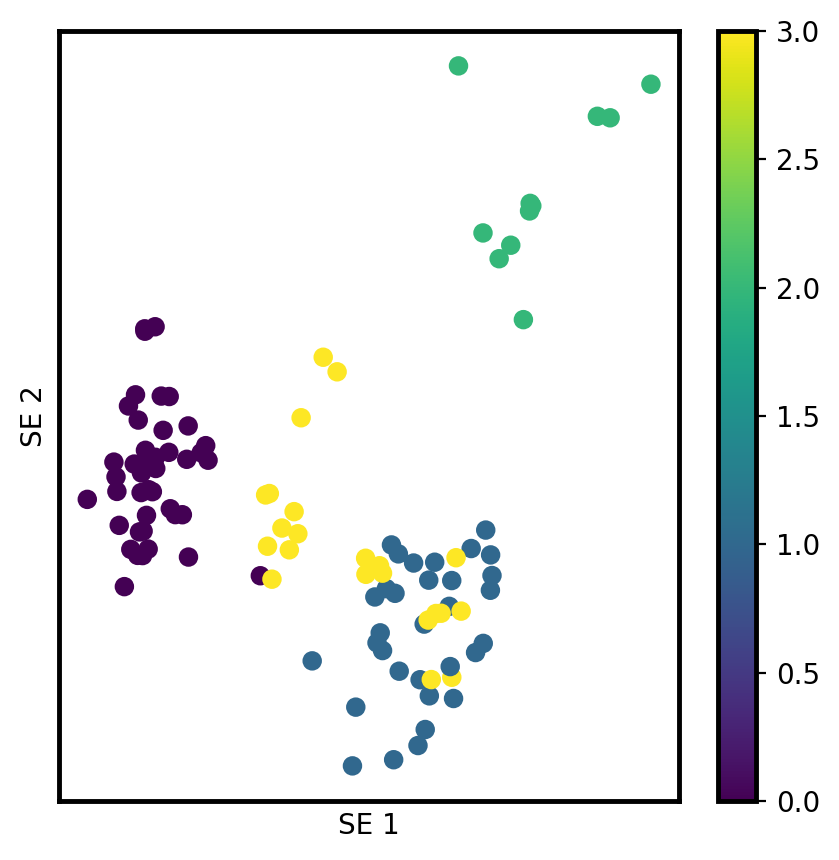

In [93]:
# make a scatter plot of the embedding and show the cluster labels
plt.figure(figsize=(5, 5))
plt.scatter(X_se[:,0], X_se[:,1], c=df_['label_se_km'], cmap='viridis')
# plt.scatter(X_se[:,0], X_se[:,1], c=df_['cluster_label'], cmap='viridis')

plt.colorbar()
# plt.plot(X_se[:,0], X_se[:,1], 'o')
plt.xlabel('SE 1')
plt.ylabel('SE 2')
# make background white
plt.gca().set_facecolor('white')
# not transparent
plt.gca().set_alpha(1)
plt.xticks([])
plt.yticks([])
# plt.legend()

plt.show()

In [94]:

df_['label_se_km'] = pd.to_numeric(df_['label_se_km'], errors='coerce')


numeric_cols = df_.select_dtypes(include=[np.number]).columns



df_[['redplspec_peakev','redplspec_intensity','photo_intensityshift', 'thermal_intensityshift', 'photo_colorshift', 'thermal_colorshift', 'label_se_km']].groupby('label_se_km').mean().T



label_se_km,0,1,2,3
redplspec_peakev,1.655981,1.656036,1.633270,1.615724
redplspec_intensity,0.619839,1.152161,5.500410,1.221658
photo_intensityshift,0.706815,0.990912,1.051110,1.567699
thermal_intensityshift,0.155378,0.167646,0.266035,0.305587
photo_colorshift,0.000698,0.000348,-0.008137,-0.002707
thermal_colorshift,-0.380144,29.439317,28.484870,17.331981


In [95]:
labels=[
        'Stable Intensity\nStable Color', #0 should be plt.cm.Pastel1(1),  # Blue 
        'Stable Intensity\nBlue Shift', #1 plt.cm.Pastel1(0),  # Red
        'Bright PL', #2 plt.cm.Pastel1(2)  , # Green
        'Brighten Intensity\nBlue Shift',] #3 plt.cm.Pastel1(3),  # Purple

df_["cluster_label"] = df_["label_se_km"].apply(lambda x: labels[x])

df_[['redplspec_peakev','redplspec_intensity','photo_intensityshift', 'thermal_intensityshift', 'photo_colorshift', 'thermal_colorshift', 'cluster_label']].groupby('cluster_label').mean().T
df_cluster_summary = df_[['redplspec_peakev','redplspec_intensity','photo_intensityshift', 'thermal_intensityshift', 'photo_colorshift', 'thermal_colorshift', 'cluster_label']].groupby('cluster_label').mean().T


df_cluster_summary.T.round(5).to_csv("df_cluster_summary.csv")
df_cluster_summary.T.round(5)

,redplspec_peakev,redplspec_intensity,photo_intensityshift,thermal_intensityshift,photo_colorshift,thermal_colorshift
cluster_label,,,,,,
Bright PL,1.63327,5.50041,1.05111,0.26603,-0.00814,28.48487
Brighten Intensity\nBlue Shift,1.61572,1.22166,1.56770,0.30559,-0.00271,17.33198
Stable Intensity\nBlue Shift,1.65604,1.15216,0.99091,0.16765,0.00035,29.43932
Stable Intensity\nStable Color,1.65598,0.61984,0.70682,0.15538,0.00070,-0.38014


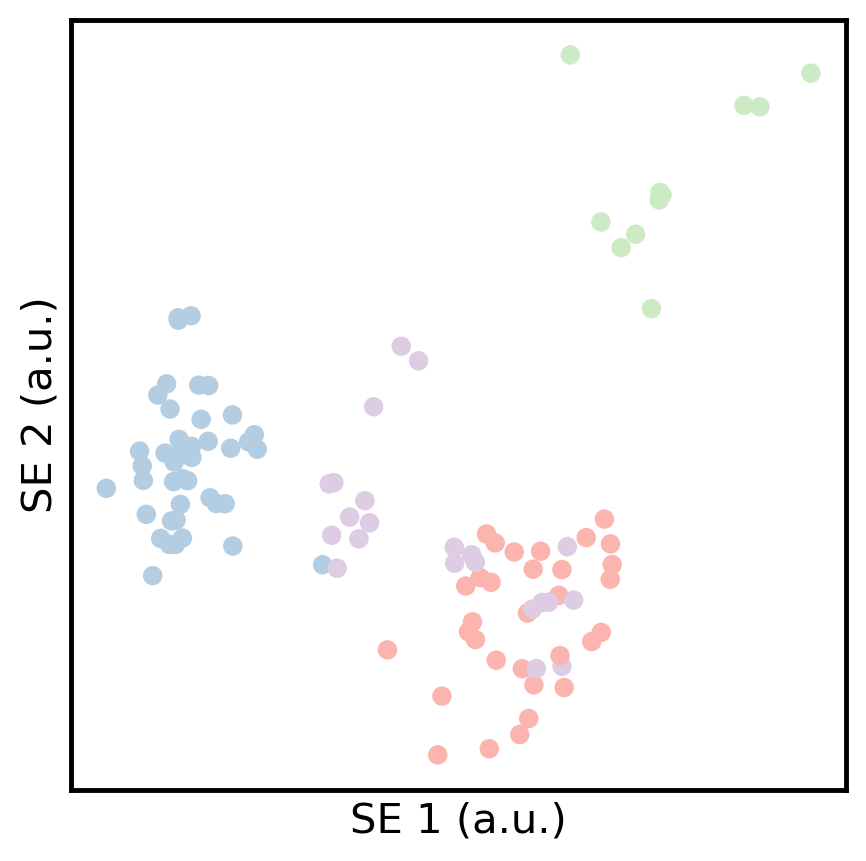

In [96]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the colormap
cmap_se = ListedColormap([
    plt.cm.Pastel1(1),  # Blue
    plt.cm.Pastel1(0),  # Red
    plt.cm.Pastel1(2),  # Green
    plt.cm.Pastel1(3)   # Purple
])


label_map = {
    'Stable Intensity\nStable Color': 0,
    'Stable Intensity\nBlue Shift': 1,
    'Bright PL': 2,
    'Brighten Intensity\nBlue Shift': 3
}

df_['color_index'] = df_['cluster_label'].map(label_map)


plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_se[:, 0], X_se[:, 1], c=df_['color_index'], cmap=cmap_se)


labels = [
    'Stable Intensity\nStable Color',
    'Stable Intensity\nBlue Shift',
    'Bright PL',
    'Brighten Intensity\nBlue Shift'
]


plt.xlabel('SE 1 (a.u.)', size = 15)
plt.ylabel('SE 2 (a.u.)', size = 15)
plt.gca().set_facecolor('white')
plt.gca().set_alpha(1)
plt.xticks([])
plt.yticks([])
plt.savefig("clustering.png", dpi=1000, bbox_inches='tight')

plt.show()


In [97]:
labels=[
        'Stable Intensity\nStable Color', #1
        'Stable Intensity\nBlue Shift', #0
        'Bright PL', #3
        'Brighten Intensity\nBlue Shift',] #2

df_["cluster_label"] = df_["label_se_km"].apply(lambda x: labels[x])

In [98]:
df_["cluster_label"]

0      Stable Intensity\nStable Color
1      Stable Intensity\nStable Color
2      Stable Intensity\nStable Color
3      Stable Intensity\nStable Color
4        Stable Intensity\nBlue Shift
                    ...              
110                         Bright PL
111    Brighten Intensity\nBlue Shift
112    Brighten Intensity\nBlue Shift
113    Brighten Intensity\nBlue Shift
114    Brighten Intensity\nBlue Shift
Name: cluster_label, Length: 108, dtype: object

In [99]:
# df_.groupby("cluster_label").mean()
df_[numeric_cols].groupby(df_['cluster_label']).mean().T


cluster_label,Bright PL,Brighten Intensity\nBlue Shift,Stable Intensity\nBlue Shift,Stable Intensity\nStable Color
MA,0.050000,0.054545,0.065625,0.055814
I,0.824273,0.885591,0.841656,0.828628
Br,0.075727,0.051091,0.097844,0.152628
Cl,0.100000,0.063318,0.060500,0.018744
redplspec_intensity,5.500410,1.221658,1.152161,0.619839
bandgap,1.557220,1.618950,1.634574,1.635505
delta_from_target_eg,0.092780,0.032455,0.022350,0.021349
original_sample_index,35.000000,16.857143,22.416667,11.538462
thermal_intensityshift,0.266035,0.305587,0.167646,0.155378
thermal_colorshift,28.484870,17.331981,29.439317,-0.380144


In [100]:
def distance_from_zero(x):
    return np.sqrt(x['thermal_colorshift']**2 + x['photo_colorshift']**2)

df_['00_diff'] = df_.apply(distance_from_zero, axis=1)

In [101]:

agg_dict = {
    'redplspec_intensity': ['mean', 'count'],
    'redplspec_fwhm': ['mean', 'count'],
    'redplspec_peakev': ['mean', 'count'],
    'photo_intensityshift': ['mean', 'count'],
    'photo_colorshift': ['mean', 'count'],
    'thermal_intensityshift': ['mean', 'count'],
    'thermal_colorshift': ['mean', 'count'],
    '00_diff': ['mean', 'count'],
    'cluster_label': lambda x: x.mode()[0]  # Getting the mode for each group
}

# Apply the aggregation
grouped = df_.groupby('compstring').agg(agg_dict)




# Flatten the MultiIndex in columns
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

# Create the df_avg DataFrame
df_avg = grouped.reset_index()

# Rename the columns to more understandable names
df_avg.rename(columns={
    'redplspec_intensity_mean': 'avg_redplspec_intensity',
    'redplspec_fwhm_mean': 'avg_redplspec_fwhm',
    'redplspec_peakev_mean': 'avg_redplspec_peakev',
    'photo_intensityshift_mean': 'avg_photo_intensityshift',
    'photo_colorshift_mean': 'avg_photo_colorshift',
    'thermal_intensityshift_mean': 'avg_thermal_intensityshift',
    'thermal_colorshift_mean': 'avg_thermal_colorshift',
    'redplspec_intensity_count': 'count_redplspec_intensity',
    '00_diff_mean': 'avg_00_diff',
    'cluster_label_<lambda>': 'cluster_label',
    # Add similar renaming for other count columns
}, inplace=True)

# Now df_avg has the average values and counts for each group in 'compstring'


In [102]:
def split_compstring(compstring):
    # Split the string by underscore and convert each part to a float
    ma, i, br, cl = map(float, compstring.split('_'))
    return ma, i, br, cl

# Apply the function to the 'compstring' column and create new columns in df_avg
df_avg[['MA', 'I', 'Br', 'Cl']] = df_avg['compstring'].apply(lambda x: pd.Series(split_compstring(x)))

# Now df_avg has additional columns 'MA', 'I', 'Br', 'Cl' with respective values


In [105]:
df_avg_stable = df_avg[df_avg['cluster_label']=='Stable Intensity\nStable Color']

In [106]:
# df_avg.to_csv("/Users/deniz/Library/CloudStorage/SynologyDrive-MyDrive/PASCAL/WBG_search/Wide Eg with Moses/Experiments/20220201 Comparing All Films/Clustering After Thermal Deg/df_avg_2.csv")

In [107]:
# df_avg_stable.to_csv("/Users/deniz/Library/CloudStorage/SynologyDrive-MyDrive/PASCAL/WBG_search/Wide Eg with Moses/Experiments/20220201 Comparing All Films/Clustering After Thermal Deg/df_avg_stable_2.csv")

In [108]:
# df_.to_csv("/Users/deniz/Library/CloudStorage/SynologyDrive-MyDrive/PASCAL/WBG_search/Wide Eg with Moses/Experiments/20220201 Comparing All Films/Clustering After Thermal Deg/df_all_2.csv")

In [109]:
# df_avg_stable = pd.read_csv("/Users/deniz/Library/CloudStorage/SynologyDrive-MyDrive/PASCAL/WBG_search/Wide Eg with Moses/Experiments/20220201 Comparing All Films/Clustering After Thermal Deg/df_stable_1.csv", index_col=0)

In [110]:
# df_avg.to_csv("/Users/deniz/Library/CloudStorage/SynologyDrive-MyDrive/PASCAL/WBG_search/Wide Eg with Moses/Experiments/20220201 Comparing All Films/Clustering After Thermal Deg/df_avg_3.csv")

In [111]:
# df_avg['avg_photo_colorshift'] = df_avg['avg_photo_colorshift'] * 1e3

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ternary/plotting.py:46: MatplotlibDeprecationWarning:

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ternary/plotting.py:48: MatplotlibDeprecationWarning:

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ternary/plotting.py:46: MatplotlibDeprecationWarning:

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the para

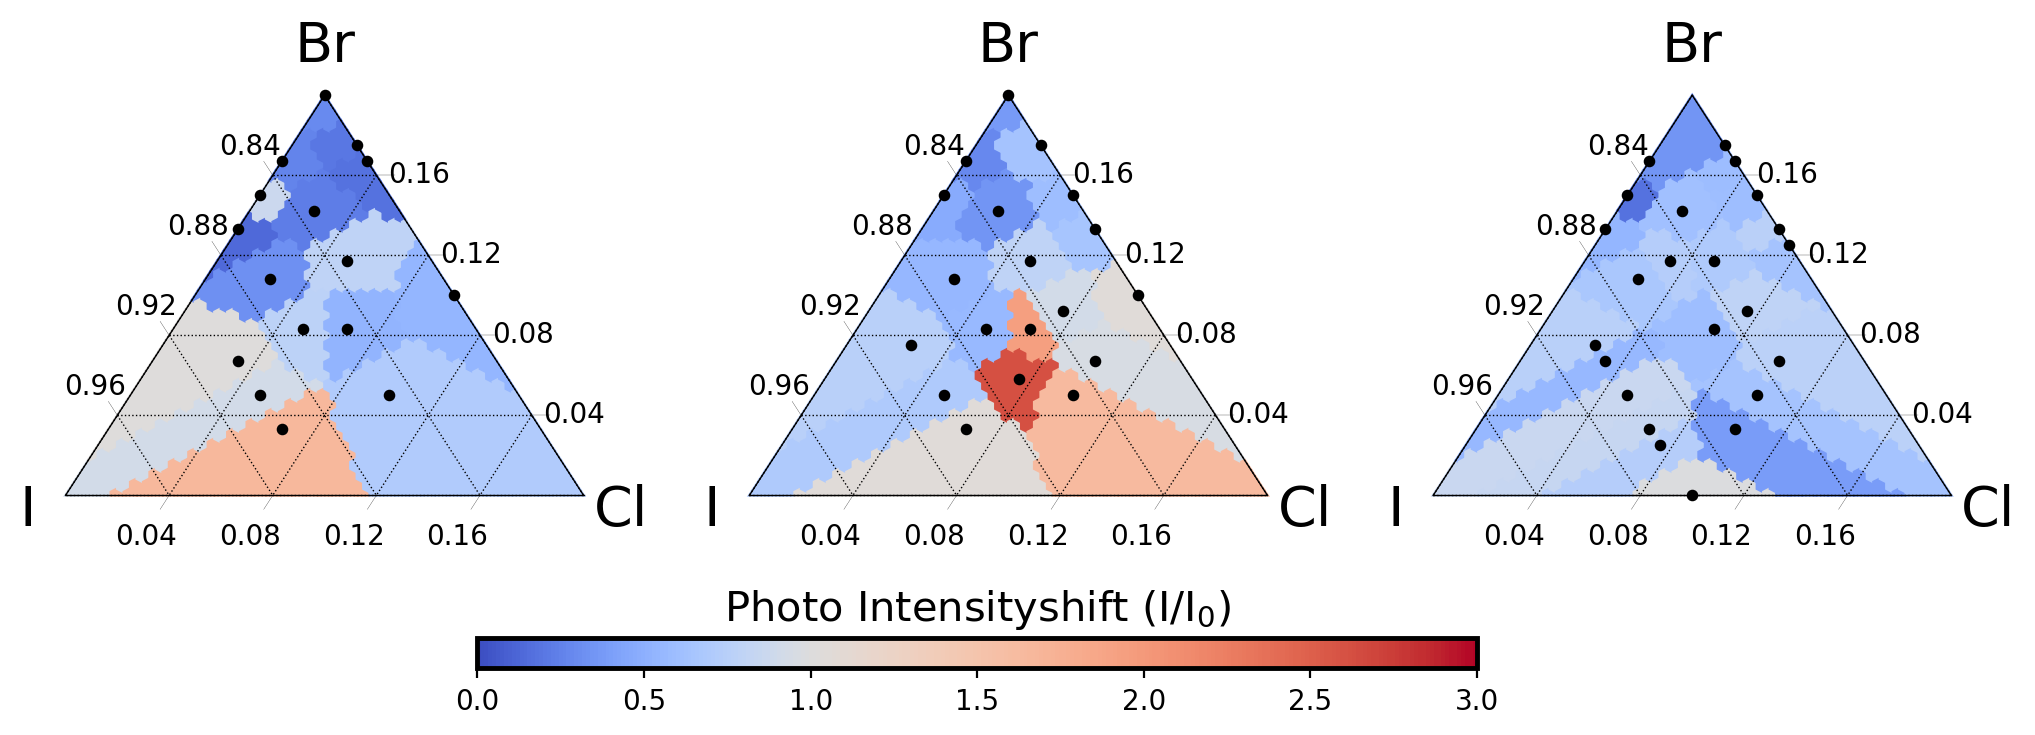

In [112]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the colormap and the range
cm = plt.cm.coolwarm
vmin, vmax = 0, 3
vcenter = 1  # Midpoint value for the colormap

# Create a custom normalization object
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# Your existing plot_three function call
fig, ax = plot_three(
    colorbar=False,
    response='avg_photo_intensityshift',
    markerfilter=None,
    cmap=cm,
    vmin=vmin,
    vmax=vmax,
    df=df_avg,
    style='hexagonal'
)

# Setting up the colorbar with the custom normalization
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm._A = []  # Dummy array for the ScalarMappable

# Adding colorbar to the figure
cax = fig.add_axes([0.3, -.1, 0.4, 0.05])  # x, y, width, height
cb = plt.colorbar(
    sm,
    cax=cax,
    orientation='horizontal'
)
cb.ax.set_title("Photo Intensityshift (I/I$_0$)", size=15)

plt.show()


/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ternary/plotting.py:46: MatplotlibDeprecationWarning:

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ternary/plotting.py:48: MatplotlibDeprecationWarning:

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ternary/plotting.py:46: MatplotlibDeprecationWarning:

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the para

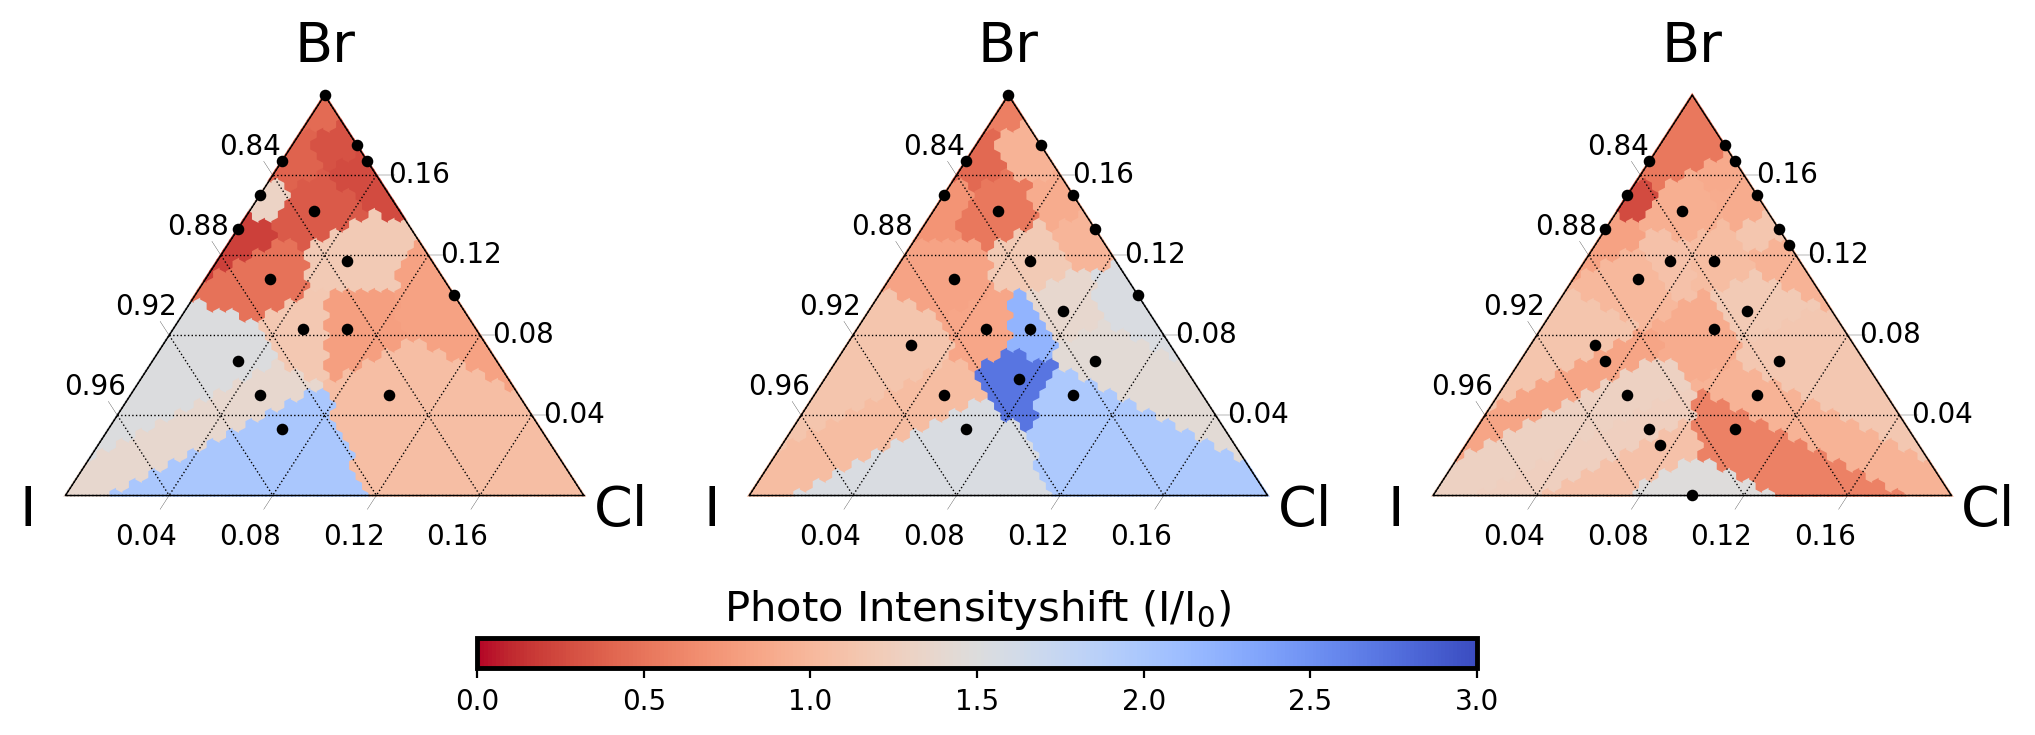

In [113]:
# plt.viridis()
# cm = plt.viridis()
cm = plt.cm.coolwarm_r
vmin, vmax = 0,3

fig, ax = plot_three(
    colorbar=False,
    response='avg_photo_intensityshift',
    markerfilter = None, #'centroid_features',#'centroid_features', #this shows circle if true or x if false for points 
    cmap=cm,
    vmin=vmin,
    vmax=vmax,
    df=df_avg,
    style='hexagonal',
    # a= (0.0,0.12),
    # b= (0.0,0.12),
    # c= (0.8,.92),
#     colorbar = False
)


norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm._A = []
cax = fig.add_axes([0.3, -.1, 0.4, 0.05]) #x,y, width, height
cb = plt.colorbar(
    sm,
    cax = cax,
    orientation = 'horizontal',
    # position = (0.3, 0, 0.4, 0.05),
    # ticks = [0,1,2,3],
)
# cb.ax.set_xticklabels(labels)
cb.ax.set_title("Photo Intensityshift (I/I$_0$)", size = 15)
plt.show()

In [114]:

MA_values = df_avg['MA'].unique()

color_values = df_avg['avg_redplspec_intensity']  
for MA in MA_values:
    df_filter = df_avg[df_avg['MA'] == MA]

    # Create the plot
    fig = plot_mesh(df_filter[['I', 'Br', 'Cl']].values, color_values=color_values, size=15)
                        # single_point=single_point_coordinates if MA == 0.05 else None)
    fig.update_layout(title_text=f'MA = {MA}', title_x=0.5)
    
    # Show the plot
    fig.show()


In [127]:
# Calculate mean composition for each cluster
centroid_composition = df_.groupby('cluster_label')[['MA', 'I', 'Br', 'Cl']].mean()

print("Centroid composition in original compositional space:")
print(centroid_composition)


Centroid composition in original compositional space:
                                      MA         I        Br        Cl
cluster_label                                                         
Bright PL                       0.050000  0.824273  0.075727  0.100000
Brighten Intensity\nBlue Shift  0.054545  0.885591  0.051091  0.063318
Stable Intensity\nBlue Shift    0.065625  0.841656  0.097844  0.060500
Stable Intensity\nStable Color  0.055814  0.828628  0.152628  0.018744


### Centroid Compositions

Nearest to feature centroids

In [116]:
dis = pairwise_distances(
    X = X,
    Y = kmeans.cluster_centers_,
    metric='sqeuclidean'
)

In [117]:
nearest_to_feature_centroids = np.argmin(dis, axis=0)

Nearest to cluster compositions centroids

In [118]:
nearest_to_composition_centroids = []

for label in range(N_CLUSTERS):
    dfsel = df_[
        df_['label_se_km'] == label
    ]
    c = dfsel[["MA", "I", "Br", "Cl"]].values
    ccent = c.mean(axis=0)
    dis = pairwise_distances(
        X = c,
        Y = ccent.reshape(1,-1),
        metric='sqeuclidean'
    )   
    nearest_to_composition_centroids.append(dfsel.index[np.argmin(dis)])

In [119]:
def label_centroids(index):
    if index in nearest_to_feature_centroids:
        return "Feature"
    elif index in nearest_to_composition_centroids:
        return "Composition"
    else:
        return "None"
df_['centroid'] = [label_centroids(i) for i in df_.index]
df_['centroid_composition'] = df_['centroid'] == "Composition"
df_['centroid_features'] = df_['centroid'] == "Feature"

In [120]:
labels

['Stable Intensity\nStable Color',
 'Stable Intensity\nBlue Shift',
 'Bright PL',
 'Brighten Intensity\nBlue Shift']

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ternary/plotting.py:46: MatplotlibDeprecationWarning:

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ternary/plotting.py:48: MatplotlibDeprecationWarning:

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ternary/plotting.py:46: MatplotlibDeprecationWarning:

Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the para

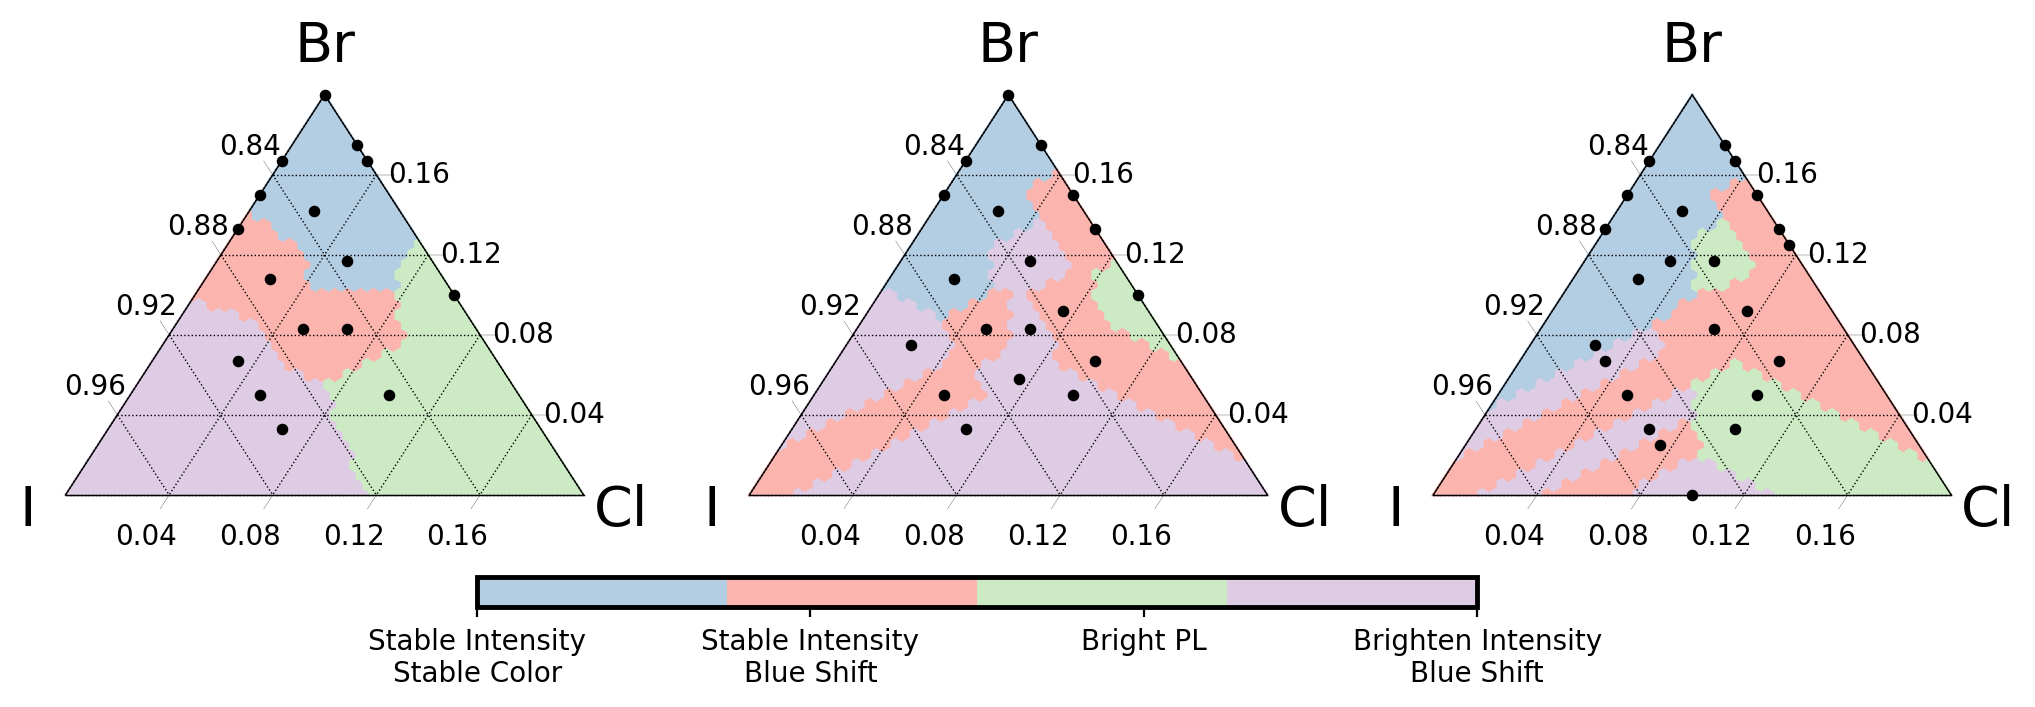

In [121]:
cmap = ListedColormap([
    plt.cm.Pastel1(1),  # Blue | Stable
    plt.cm.Pastel1(0),  # Red | Stable Intensity Redshift
    plt.cm.Pastel1(2)  , # Green |  Bright 
    plt.cm.Pastel1(3),  # Purple | Brighten Intensity, Red Shift
])

fig, ax = plot_three(
    colorbar=False,
    response='label_se_km',
    markerfilter = None, #'centroid_features',#'centroid_features', #this shows circle if true or x if false for points 
    cmap=cmap,
    vmin=0,
    vmax=N_CLUSTERS-1,
    df=df_,
    style='hexagonal',
    # a= (0.0,0.12),
    # b= (0.0,0.12),
    # c= (0.8,.92),
#     colorbar = False
)


norm = plt.Normalize(vmin=0, vmax=N_CLUSTERS-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cax = fig.add_axes([0.3, 0, 0.4, 0.05]) #x,y, width, height
cb = plt.colorbar(
    sm,
    cax = cax,
    orientation = 'horizontal',
    ticks = [0,1,2,3],
)
cb.ax.set_xticklabels(labels)
plt.show()

In [128]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors as mcolors

hover_text = df_.index.astype(str) + ': ' + df_['compstring']

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

symbol_size = 20
# Convert ListedColormap to a list of hex color codes
colors = [mcolors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, cmap.N)]


unique_labels = sorted(df_['label_se_km'].unique())
color_mapping = dict(zip(unique_labels, colors))

# Apply color mapping to DataFrame
df_['color'] = df_['label_se_km'].map(color_mapping)

# Create subplots
fig = make_subplots(rows=1, cols=3)#, subplot_titles=("Plot 1", "Plot 2", "Plot 3"))


# Plot 2 with hover info and color mapping
fig.add_trace(go.Scatter(
    x=df_['thermal_intensityshift'],
    y=df_['photo_intensityshift'],
    mode='markers',
    marker=dict(
        color=df_['color'],
        size=df_['centroid'].map({"Composition": symbol_size, "Feature": symbol_size, "None": symbol_size}),

        # symbol=df_['centroid'].map({"Composition": "x", "Feature": "circle", "None": "circle"}),
        # size=df_['centroid'].map({"Composition": 15, "Feature": 7, "None": 7}),

        # size=df_['centroid'].map({"Composition": 10, "Feature": 7, "None": 5}),
        # symbol=df_['centroid'].map({"Composition": "circle", "Feature": "square", "None": "diamond"}),
    ),
    text=hover_text,  # Hover text
    hoverinfo='text+x+y',
    showlegend=False,
), row=1, col=2)

# Add horizontal and vertical lines
fig.add_hline(y=1, line_dash="dash", line_color="black", row=1, col=2)
fig.add_vline(x=1, line_dash="dash", line_color="black", row=1, col=2)

# Plot 3 with hover info and color mapping
fig.add_trace(go.Scatter(
    x=df_['thermal_colorshift'],
    y=df_['photo_colorshift']*1e3,
    mode='markers',
    marker=dict(
        color=df_['color'],
        size=df_['centroid'].map({"Composition": symbol_size, "Feature": symbol_size, "None": symbol_size}),

        # symbol=df_['centroid'].map({"Composition": "x", "Feature": "circle", "None": "circle"}),
        # size=df_['centroid'].map({"Composition": 15, "Feature": 7, "None": 7}),

        # size=df_['centroid'].map({"Composition": 10, "Feature": 7, "None": 5}),
        # symbol=df_['centroid'].map({"Composition": "circle", "Feature": "square", "None": "diamond"}),
    ),
    text=hover_text,  # Hover text
    hoverinfo='text+x+y',
    showlegend=False,
), row=1, col=1)

# Add horizontal and vertical lines
fig.add_hline(y=0, line_dash="dash", line_color="black", row=1, col=1)
fig.add_vline(x=0, line_dash="dash", line_color="black", row=1, col=1)



axis_label_size = 30
fig.update_xaxes(title_text="PL Intensity (a.u.)", 
                 title_font={"size": axis_label_size}, 
                 row=1, col=3)
fig.update_yaxes(title_text="PL Emission Center (eV)", 
                 title_font={"size": axis_label_size}, 
                 row=1, col=3)

# Update axes titles with subscripts using HTML-like formatting
fig.update_xaxes(title_text="Thermal: Intensity Change (I/I<sub>0</sub>)", 
                 title_font={"size": axis_label_size}, 
                 row=1, col=2)
fig.update_yaxes(title_text="Photo: Intensity Change (I/I<sub>0</sub>)", 
                 title_font={"size": axis_label_size}, 
                 row=1, col=2)
fig.update_xaxes(title_text="Thermal: PL Emission Center Shift (meV)", 
                 title_font={"size": axis_label_size}, 
                 row=1, col=1)
fig.update_yaxes(title_text="Photo: PL Emission Center Shift (meV)", 
                 title_font={"size": axis_label_size}, 
                 row=1, col=1)


# Plot 1 with hover info and color mapping
fig.add_trace(go.Scatter(
    x=df_['redplspec_intensity'],
    y=df_['redplspec_peakev'],
    mode='markers',
    marker=dict(
        color=df_['color'],  # Apply color mapping
        size=df_['centroid'].map({"Composition": symbol_size, "Feature": symbol_size, "None": symbol_size}),
        # symbol=df_['centroid'].map({"Composition": "circle", "Feature": "square", "None": "diamond"}),
        # symbol=df_['centroid'].map({"Composition": "x", "Feature": "circle", "None": "circle"}),

    ),
    text=hover_text,  # Hover text
    hoverinfo='text+x+y',  # Show hover text along with x and y values
    showlegend=False,
    #xlim and y lim
    
    
), row=1, col=3)





# Layout adjustments
fig.update_layout(
    height=2150/3, width=2000,
    showlegend=False,
    # title_text="Your Plots",
    paper_bgcolor='white',  # Set the background color to white
    plot_bgcolor='white',   # Set the plotting area background to white
)

## Update axes with larger tick labels
fig.update_xaxes(
    linecolor='black',  # Set x-axis line color to black
    tickcolor='black',  # Set x-axis tick color to black
    tickwidth=2,       # Set x-axis tick width
    ticklen=10,        # Set x-axis tick length
    title_font=dict(color='black'),  # Set x-axis title color to black
    tickfont=dict(size=20, color='black'),  # Increase x-axis tick label size
    showgrid=True,  # Optionally, show gridlines
    gridcolor='lightgrey'  # Optionally, set gridline color
)
fig.update_yaxes(
    linecolor='black',  # Set y-axis line color to black
    tickcolor='black',  # Set y-axis tick color to black
    tickwidth=2,       # Set y-axis tick width
    ticklen=10,        # Set y-axis tick length
    title_font=dict(color='black'),  # Set y-axis title color to black
    tickfont=dict(size=20, color='black'),  # Increase y-axis tick label size
    showgrid=True,  # Optionally, show gridlines
    gridcolor='lightgrey'  # Optionally, set gridline color
)


fig.show()


In [123]:
# Group by the cluster label
grouped = df_.groupby('cluster_label')

# Calculate the centroid for each cluster in the scatter plot space
scatter_centroids = grouped[['photo_colorshift', 'thermal_colorshift']].mean()

print("Centroid in scatter plot space:")
print(scatter_centroids)


Centroid in scatter plot space:
                                photo_colorshift  thermal_colorshift
cluster_label                                                       
Bright PL                              -0.008137           28.484870
Brighten Intensity\nBlue Shift         -0.002707           17.331981
Stable Intensity\nBlue Shift            0.000348           29.439317
Stable Intensity\nStable Color          0.000698           -0.380144


In [124]:
# Group by the cluster label
grouped = df_.groupby('cluster_label')

# Calculate the centroid for each cluster in the scatter plot space
scatter_centroids = grouped[['photo_intensityshift', 'thermal_intensityshift']].mean()

print("Centroid in scatter plot space:")
print(scatter_centroids)


Centroid in scatter plot space:
                                photo_intensityshift  thermal_intensityshift
cluster_label                                                               
Bright PL                                   1.051110                0.266035
Brighten Intensity\nBlue Shift              1.567699                0.305587
Stable Intensity\nBlue Shift                0.990912                0.167646
Stable Intensity\nStable Color              0.706815                0.155378


## BO:EI

In [125]:
df = df_avg_stable

In [126]:
df[['I', 'Br', 'Cl', 'MA','avg_00_diff']].sort_values(by=['avg_00_diff'], ascending=False)

,I,Br,Cl,MA,avg_00_diff
38,0.800,0.167,0.033,0.10,6.144760
47,0.850,0.117,0.033,0.10,6.125671
43,0.833,0.142,0.025,0.10,5.869620
50,0.867,0.108,0.025,0.10,4.653294
5,0.833,0.142,0.025,0.00,4.249285
57,0.900,0.075,0.025,0.10,3.026172
39,0.800,0.175,0.025,0.10,2.314720
3,0.800,0.200,0.000,0.00,2.292306
6,0.833,0.167,0.000,0.00,1.963575
4,0.833,0.117,0.050,0.00,1.476097


In [199]:
df['I'] = pd.to_numeric(df['I'], errors='coerce').fillna(0)
df['Br'] = pd.to_numeric(df['Br'], errors='coerce').fillna(0)
df['Cl'] = pd.to_numeric(df['Cl'], errors='coerce').fillna(0)
df['MA'] = pd.to_numeric(df['MA'], errors='coerce').fillna(0)

/var/folders/cg/npjcl03j1_g_q4sw465xcyx00000gn/T/ipykernel_9102/1217521289.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cg/npjcl03j1_g_q4sw465xcyx00000gn/T/ipykernel_9102/1217521289.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cg/npjcl03j1_g_q4sw465xcyx00000gn/T/ipykernel_9102/1217521289.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

### Expected Improvement

In [68]:
df['avg_00_diff_negative'] = -df['avg_00_diff']

/var/folders/cg/npjcl03j1_g_q4sw465xcyx00000gn/T/ipykernel_34676/2780422099.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
df_ML = df

In [71]:
def evaluate_acquisition_function_4d(ax_client, search_parameters, metrics, weights):
    model = ax_client.generation_strategy.model
    if model is None:
        raise ValueError("Model has not been initialized")

    # Define evaluation points for each parameter
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], 101)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], 101)
    z_eval = np.linspace(search_parameters[2]['bounds'][0], search_parameters[2]['bounds'][1], 101)

    # Initialize the array for storing acquisition values
    acq_values = np.zeros((len(x_eval), len(y_eval), len(z_eval)))
    metric_names = [metric.name for metric in metrics]

    # Iterate over all combinations of parameters
    for i, x in enumerate(x_eval):
        for j, y in enumerate(y_eval):
            if x + y >= 0.95 and x + y <= 1:
                for k, z in enumerate(z_eval):
                    # Create ObservationFeatures for the current parameter combination
                    plot_parameters = [ObservationFeatures(parameters={'I': x, 'Br': y, 'MA': z})]

                    # Predict the acquisition values
                    acq_values_dict, _ = model.predict(plot_parameters)

                    # Compute the scalarized acquisition value
                    scalarized_acq_value = 0
                    for metric_name, weight in zip(metric_names, weights):
                        acq_value = acq_values_dict[metric_name][0]
                        scalarized_acq_value += weight * acq_value

                    # Store the computed value
                    acq_values[i, j, k] = scalarized_acq_value
            else:
                acq_values[i, j] = np.nan

    return acq_values



def get_batch_trial_indices(ax_client, num_trials, min_distance=None):
    if min_distance is not None:
        return enforce_minimum_distance(ax_client, num_trials=num_trials, min_distance=min_distance)
    else:
        trial_indices, _ = ax_client.get_next_trials(num_trials)
        return trial_indices
    
def create_mesh_array_4d(search_parameters, num_points=101):
    x_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], num_points)
    y_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], num_points)
    z_eval = np.linspace(search_parameters[2]['bounds'][0], search_parameters[2]['bounds'][1], num_points)

    mesh_array = np.zeros((len(x_eval), len(y_eval), len(z_eval), 3))
    for i, x in enumerate(x_eval):
        for j, y in enumerate(y_eval):
            for k, z in enumerate(z_eval):
                mesh_array[i, j, k, :] = [x, y, z]
    return mesh_array


def complete_trials_4d(ax_client, df, standard_errors):
    for _, row in df.iterrows():
        metrics_data = {}
        for metric, standard_error in standard_errors.items():
            if pd.notnull(row[metric]):
                metrics_data[metric] = (row[metric], standard_error)
        if metrics_data:
            trial_parameters = {'I': row['I'], 'Br': row['Br'], 'MA': row['MA']}
            _, trial_index = ax_client.attach_trial(trial_parameters)
            ax_client.complete_trial(trial_index=trial_index, raw_data=metrics_data)

In [72]:
# requires python 3.10
df = df_ML#[df_ML['MA'] == 0.1]
ax_client = AxClient()

num_trials = 15

# Define your metrics
metrics = [
    # L2NormMetric('emission_energy_difference_negative', param_names=['I', 'Br']),
    L2NormMetric('avg_00_diff_negative', param_names=['I', 'Br', 'MA']),
    # L2NormMetric('ps_peakev_delta_0_negative', param_names=['I', 'Br']),
]

# Create a ScalarizedObjective
weights = [1]
objective = ScalarizedObjective(metrics=metrics, weights=weights)

# Create an ScalarizedOptimizationConfig
optimization_config = OptimizationConfig(objective=objective)

# Define a dictionary that maps each metric to its corresponding standard error
standard_errors = {
    # 'emission_energy_difference_negative': 0.00226,
    'avg_00_diff_negative': 0.001,
    # 'ps_peakev_delta_0_negative': 0.00226,
}

# Define your search space and optimization parameters
search_parameters = [
    {"name": "I", "type": "range", "bounds": [0.8, .95]},
    {"name": "Br", "type": "range", "bounds": [0.0, .2]},
    {"name": "MA", "type": "range", "bounds": [0.0, .1]},
]

# Add a sum constraint
parameter_constraints = ["I + Br >= .95", "I + Br <= 1"]

# Define the generation strategy

gs = GenerationStrategy(
    name="CustomStrategy_GPEI_ONLY",
    steps=[
        GenerationStep(
            model=get_GPEI, 
            num_trials=num_trials, 
            # model_kwargs={
            #     # "nu": 2,
            #     "acquisition_function_kwargs": {"xi": .01},
            # }
        )
    ],
)


gs_qNEI = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=num_trials,
            model_kwargs={
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNoisyExpectedImprovement,
            },
        ),
    ]
)

# Initialize the AxClient
ax_client = AxClient(generation_strategy=gs_qNEI, verbose_logging=True)

# Create the experiment
create_experiment(
    ax_client, 
    search_parameters, 
    {
        # 'emission_energy_difference_negative': ObjectiveProperties(minimize=True),
        'avg_00_diff_negative': ObjectiveProperties(minimize=False), 
        # 'ps_peakev_delta_0_negative': ObjectiveProperties(minimize=True),
    }, 
    parameter_constraints
)

# Set the optimization config on your experiment
ax_client.experiment.optimization_config = optimization_config

# Complete trials
complete_trials_4d(ax_client, df, standard_errors)

# Get batch_trial_indices
enforce_min_distance = False  # Set this to True if you want to enforce minimum distance
min_distance = 0.05 if enforce_min_distance else None

batch_trial_indices = get_batch_trial_indices(ax_client, num_trials=15, min_distance=min_distance)

# Create a DataFrame of the suggested samples
# df_suggested = create_suggested_samples_df(ax_client, batch_trial_indices)

# Evaluate the acquisition function
acq_values_1 = evaluate_acquisition_function_4d(ax_client, search_parameters, metrics, weights)

# df_new = complete_trials_and_get_new_df(ax_client, batch_trial_indices, df)

# print(df_suggested)

[INFO 02-01 00:48:16] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
/Users/deniz/anaconda3/envs/ds310/lib/python3.10/site-packages/ax/modelbridge/model_spec.py:313: UserWarning:

Using a factory function to describe the model, so optimization state cannot be stored and optimization is not resumable if interrupted.

[INFO 02-01 00:48:16] ax.modelbridge.generation_strategy: Using model via callable function, so optimization is not resumable if interrupted.
[INFO 02-01 00:48:16] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-01 00:48:16] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter I. If that is not the expected value type, you can e

KeyboardInterrupt: 

In [207]:
# # Save as a .pkl file
# with open('acq_values_4d_2.pkl', 'wb') as f:
#     pkl.dump(acq_values_1, f)

In [73]:
acq_values_1 = np.load('acq_values_4d.pkl', allow_pickle=True)

In [74]:
def create_mesh_array_4d(search_parameters, acq_values, num_points=101):

    # Define evaluation points for each parameter
    i_eval = np.linspace(search_parameters[0]['bounds'][0], search_parameters[0]['bounds'][1], num_points)
    br_eval = np.linspace(search_parameters[1]['bounds'][0], search_parameters[1]['bounds'][1], num_points)
    ma_eval = np.linspace(search_parameters[2]['bounds'][0], search_parameters[2]['bounds'][1], num_points)

    # Create a mesh grid
    I, Br, MA = np.meshgrid(i_eval, br_eval, ma_eval, indexing='ij')

    # Compute 'Cl' = 1 - 'I' - 'Br'
    Cl = 1 - I - Br

    # Initialize the mesh array with an additional dimension for acquisition values
    mesh_array = np.zeros((len(i_eval), len(br_eval), len(ma_eval), 5))

    # Populate the mesh array
    mesh_array[:, :, :, 0] = I
    mesh_array[:, :, :, 1] = Br
    mesh_array[:, :, :, 2] = MA
    mesh_array[:, :, :, 3] = Cl
    mesh_array[:, :, :, 4] = acq_values

    return mesh_array


In [75]:
def flatten_mesh_array(mesh_array, acq_values):
    original_mesh_shape = mesh_array.shape
    original_acq_shape = acq_values.shape

    # Since mesh_array is 4D with the last dimension being 5, we reshape it to (-1, 5)
    flattened_mesh_array = mesh_array.reshape(-1, 5)
    flattened_acq_values = acq_values.flatten()

    return flattened_mesh_array, flattened_acq_values, original_mesh_shape, original_acq_shape


In [78]:
# Create a mesh array from the evaluation points
mesh_array = create_mesh_array_4d(search_parameters, acq_values_1)

# Assuming acq_values is a numpy array that you want to flatten
# Example: acq_values = np.random.rand(101, 101, 101)  # Replace with your actual acquisition values

mesh_array_flat, acq_values_flat, original_mesh_shape, original_acq_shape = flatten_mesh_array(mesh_array, acq_values_1)


# flatten_mesh_array(mesh_array):
#     return mesh_array.reshape(-1, 3), acq_values.flatten()

# Flatten the mesh array and acquisition function values for plotting

# # Plot the acquisition function on a ternary plot
# fig = plot_acquisition_function(mesh_array_flat, acq_values_flat)

# # Plot the data points
# # fig = plot_data_points(df, df_suggested, fig)

# fig.show()

In [79]:
import numpy as np

# Create a mask where the fourth dimension of mesh_array is >= 0
mask = mesh_array[:, :, :, 3] >= 0

# Apply this mask to acq_values_1 to filter the data
filtered_acq_values = np.where(mask, acq_values_1, np.nan)

# Find the maximum value in the filtered data
max_value = np.nanmax(filtered_acq_values)

# Find the location of the maximum value in the filtered data
location_of_max = np.unravel_index(np.nanargmax(filtered_acq_values), filtered_acq_values.shape)

# Get the corresponding values from mesh_array
max_parameters = mesh_array[location_of_max]

max_value, location_of_max, max_parameters


(-0.21967972549230552,
 (44, 67, 35),
 array([ 0.866     ,  0.134     ,  0.035     ,  0.        , -0.21967973]))

In [81]:
import plotly.graph_objects as go

def plot_BO_mesh(mesh_array, acq_values, fig=None, symbol='circle', **marker_kwargs):
    # If no figure is provided, create a new one
    if fig is None:
        fig = go.Figure()

    # Add the mesh points to the figure
    fig.add_trace(go.Scatterternary(a=mesh_array[:, 1],  # 'Br'
                                    b=mesh_array[:, 0],  # 'I'
                                    c=mesh_array[:, 3],  # 'Cl'
                                    mode='markers',
                                    marker=dict(color=acq_values, colorscale='Viridis', symbol=symbol, **marker_kwargs)))

    # Set axis labels
    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")

    # Update axes ranges
    fig.update_ternaries(sum=1, baxis_min=.8)  # Update for I axis

    # Change layout options
    fig.update_layout({
        'plot_bgcolor': 'white',  # Make plot background white
        'paper_bgcolor': 'white',  # Make paper background white
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    return fig  # Return the updated figure object

def plot_acquisition_function(mesh_array_flat, acq_values_flat):#, color_scale_range=None):
    fig = plot_BO_mesh(mesh_array_flat, acq_values_flat)#, color_scale_range=color_scale_range)
    return fig


In [94]:
import plotly.graph_objects as go

def plot_acquisition_function(mesh_array_flat, acq_values_flat, color_scale_range=None, ma_value=0):
    fig = plot_BO_mesh(mesh_array_flat, acq_values_flat, color_scale_range=color_scale_range, ma_value=ma_value)
    return fig

def plot_BO_mesh(mesh_array, acq_values, fig=None, symbol='circle', color_scale_range=None, ma_value=0, **marker_kwargs):
    # If no figure is provided, create a new one
    if fig is None:
        fig = go.Figure()

    # Define the color scale for the markers
    marker_color = dict(color=acq_values, colorscale='Viridis', symbol=symbol, **marker_kwargs)
    if color_scale_range is not None:
        marker_color['cmin'] = color_scale_range[0]
        marker_color['cmax'] = color_scale_range[1]

    # Add the mesh points to the figure
    fig.add_trace(go.Scatterternary(a=mesh_array[:, 1], b=mesh_array[:, 0], c=mesh_array[:, 3], mode='markers', 
                                    marker=marker_color))

    # Set axis labels
    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")

    # Update axes ranges
    fig.update_ternaries(sum=1, baxis_min=.8)  # update for I axis

    # Change layout options
    fig.update_layout({
        'plot_bgcolor': 'white',  # make plot background white
        'paper_bgcolor': 'white',  # make paper background white
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    # Add the ma_value annotation underneath the ternary triangle
    annotation_x = 0.5  # X-coordinate for the annotation
    annotation_y = -0.2  # Y-coordinate for the annotation
    fig.add_annotation(
        go.layout.Annotation(
            x=annotation_x,
            y=annotation_y,
            text=f'{ma_value*1e2:.4f}% MA',
            showarrow=False,
            font=dict(size=12, color='black'),
        )
    )

    return fig  # return the updated figure object


In [83]:
df_star = pd.DataFrame({'I': [0.863], 'Br': [0.132], 'Cl': [0.005]})

In [84]:
df_star['temp'] = 1

In [95]:
import numpy as np

def extract_slice_at_ma(mesh_array, acq_values, ma_value, ma_index=2):
    """
    Extracts a slice of the mesh array and acquisition values where 'MA' equals a specific value.

    Args:
        mesh_array (np.ndarray): The 4D mesh array.
        acq_values (np.ndarray): The 3D array of acquisition values.
        ma_value (float): The specific value of 'MA' to extract the slice at.
        ma_index (int): The index of the 'MA' dimension in the mesh array. Defaults to 2.

    Returns:
        np.ndarray: The flattened slice of the mesh array at the specified 'MA' value.
        np.ndarray: The flattened acquisition values corresponding to the slice.
    """
    # Find the closest index to the specified 'MA' value
    ma_values = np.linspace(search_parameters[ma_index]['bounds'][0], 
                            search_parameters[ma_index]['bounds'][1], 
                            mesh_array.shape[ma_index])
    ma_closest_index = np.argmin(np.abs(ma_values - ma_value))

    # Extract the slice for the specified 'MA' value
    slice_mesh_array = mesh_array[:, :, ma_closest_index, :]
    slice_acq_values = acq_values[:, :, ma_closest_index]

    # Flatten the extracted slice
    flattened_slice_mesh_array = slice_mesh_array.reshape(-1, slice_mesh_array.shape[-1])
    flattened_slice_acq_values = slice_acq_values.flatten()

    return flattened_slice_mesh_array, flattened_slice_acq_values


# Assuming you have already defined your `plot_acquisition_function` and `extract_slice_at_ma` functions

# Example usage
ma_value = 0.032 # Specify the 'MA' value for the slice

# Call the `extract_slice_at_ma` function to extract the slice at the specified 'MA' value
slice_mesh_array_flat, slice_acq_values_flat = extract_slice_at_ma(mesh_array, acq_values_1, ma_value=ma_value)

# Now you can plot this slice using the `plot_acquisition_function` function
fig = plot_acquisition_function(slice_mesh_array_flat, slice_acq_values_flat, color_scale_range=(np.nanmax(acq_values_1), np.nanmin(acq_values_1)), ma_value=ma_value)

# Display the plot
fig.show()



In [97]:
import os
import numpy as np

def generate_acquisition_plots(mesh_array, acq_values, start_ma, end_ma, num_steps, directory='/Users/deniz/Library/CloudStorage/SynologyDrive-MyDrive/PASCAL/WBG_search/Wide Eg with Moses/Experiments/20220201 Comparing All Films/Clustering After Thermal Deg/frames'):
    """
    Generate and save plots for a range of 'MA' values.

    Args:
        mesh_array (np.ndarray): The 4D mesh array.
        acq_values (np.ndarray): The 3D array of acquisition values.
        start_ma (float): The starting value of 'MA'.
        end_ma (float): The ending value of 'MA'.
        num_steps (int): Number of steps between start_ma and end_ma.
        directory (str): Directory to save the plot images.
    """
    # Create the directory if it does not exist
    os.makedirs(directory, exist_ok=True)

    # Generate values for 'MA'
    ma_values = np.linspace(start_ma, end_ma, num_steps)
    # ma_values = np.array([0, .035, .07, .1])

    # Generate and save plots for each 'MA' value
    for ma_value in ma_values:
        # Extract the slice for the given 'MA' value
        slice_mesh_array_flat, slice_acq_values_flat = extract_slice_at_ma(mesh_array, acq_values, ma_value=ma_value)

        # Generate the plot
        fig = plot_acquisition_function(slice_mesh_array_flat, slice_acq_values_flat, color_scale_range=(np.nanmax(acq_values_1), np.nanmin(acq_values_1)), ma_value=ma_value)

        # Save the plot as an image
        fig.write_image(f"{directory}/frame_{ma_value:.4f}.png")

# Example usage

generate_acquisition_plots(mesh_array, acq_values_1, start_ma=0, end_ma=0.1, num_steps=101)


In [98]:
from moviepy.editor import ImageSequenceClip
import os

# Directory containing the .png files
directory = "/Users/deniz/Library/CloudStorage/SynologyDrive-MyDrive/PASCAL/WBG_search/Wide Eg with Moses/Experiments/20220201 Comparing All Films/Clustering After Thermal Deg/frames"  # Change this to your directory path

# List all files in the directory and filter out non-.png files
frame_filepaths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.png')]

# Sort the file paths by name
frame_filepaths.sort()

# Assuming all frames are present and correct
clip = ImageSequenceClip(frame_filepaths, fps=20)

# Write the video file
clip.write_videofile("ma_value_variation_2.mp4")


Moviepy - Building video ma_value_variation_2.mp4.
Moviepy - Writing video ma_value_variation_2.mp4



Moviepy - Done !
Moviepy - video ready ma_value_variation_2.mp4


----- 

# Old code


## Pareto Fronts

In [ ]:
df_.columns

In [ ]:
df = df_.copy()

In [ ]:
def is_pareto(costs, maximise=False):
    """
    :param costs: An (n_points, n_costs) array
    :maximise: boolean. True for maximising, False for minimising
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            if maximise:
                is_efficient[is_efficient] = np.any(costs[is_efficient]>=c, axis=1)  # Remove dominated points
            else:
                is_efficient[is_efficient] = np.any(costs[is_efficient]<=c, axis=1)  # Remove dominated points
    return is_efficient

In [ ]:
# egwidth = 0.015
# egcenters = [1.62, 1.65, 1.68]
# def get_band(e):
#     for c in egcenters:
#         if np.abs(e-c) <= egwidth:
#             return c
#     return 'none'
# df['egband'] = df['redplspec_peakev'].apply(get_band)

In [ ]:
df["thermal_shift"] = -np.abs(df["delta_bandgap"])
df["thermal_pl"] = df["ratio_plintensity"]
df["photo_shift"] = -np.abs(df["photostability_peakev_delta"])
df["photo_pl"] = df["photostability_peakev_delta"]

In [ ]:
df["delta_targeteg"] = -np.abs(df["redplspec_peakev"]-1.67)*1e3

In [ ]:
CLUSTERS = df["cluster"].unique()
CLUSTERS

In [ ]:
cost_cols = [
    "redplspec_intensity",
    "delta_targeteg"
]

In [ ]:
df_ = df[
    df["cluster"] == CLUSTERS[3]
]

In [ ]:
def is_pareto_per_cluster(c):
    dfc = df[df["cluster"] == c]
    costs = dfc[cost_cols].values
    po = is_pareto(costs, maximise=True)
    dfc["pareto_for_cluster"] = po
    return dfc[["MA", "I", "Br", "Cl", "pareto_for_cluster"]]

In [ ]:
pdf = pd.concat([
    is_pareto_per_cluster(c)
    for c in df["cluster"].unique()
])

In [ ]:
df = df.merge(pdf, on=["MA", "I", "Br", "Cl"])

In [ ]:
df["bandgap"] = df["redplspec_peakev"]

In [ ]:
feat_cols

In [ ]:
df[df["pareto_for_cluster"]].groupby('cluster')[["cluster", "MA", "I", "Br", "Cl", "redplspec_intensity", "bandgap", "centroid_features"] + feat_cols[1:]].apply(display)

In [ ]:
df[df["cluster"]==CLUSTERS[1]][["cluster", "MA", "I", "Br", "Cl", "redplspec_intensity", "bandgap", "centroid_features"] + feat_cols[1:]]

In [ ]:
df_downselected = df[
    (df["pareto_for_cluster"])
    | (df["centroid_features"])
][["cluster", "MA", "I", "Br", "Cl", "redplspec_intensity", "bandgap", "centroid_features"] + feat_cols[1:]]\
    .sort_values(["cluster", "centroid_features", "redplspec_intensity", "bandgap"])

df_downselected

In [ ]:
df_downselected.to_csv("20231127_downselection.csv")

In [ ]:
# grouped = df_.groupby('label_se_km')

# # Creating scatter plots for each subgroup
# for name, group in grouped:
#     plt.scatter(group['delta_plpeakev'], group['photostability_peakev_delta'], label=name)

# plt.xlabel('delta_plpeakev')
# plt.ylabel('photostability_peakev_delta')
# plt.title('Scatter Plot of Subgroups')
# plt.legend()
# plt.show()


In [ ]:
# fig, ax = plt.subplots(1,3, figsize = (12,4))

# sns.scatterplot(
#     data = df_,
#     y = "redplspec_peakev",
#     x = "redplspec_intensity",
#     hue = "label_se_km",
#     style = "centroid",
#     size = "centroid",
#     size_order = ["Composition", "Feature", "None"],
#     palette = cmap,
#     ax = ax[0],
#     legend=False,
# )
# ax[0].axhline(1.67, linestyle="--", color="k", alpha=0.5)
# # ax[0].axvline(1, linestyle="--", color="k", alpha=0.05)
# # ax[0].set_ylabel(r"Photo: PL FWHM Change (meV)")
# ax[0].set_ylabel(r"Emission Energy (eV)")
# ax[0].set_xlabel(r"PL Intensity As-Fabricated (AU)")
# ax[0].set_ylim([1.55,1.7])



# sns.scatterplot(
#     data = df_,
#     x = "ratio_plintensity",
#     y = "photostability_intensity_normdelta",
#     hue = "label_se_km",
#     style = "centroid",
#     size = "centroid",
#     size_order = ["Composition", "Feature", "None"],
#     palette = cmap,
#     ax = ax[1],
#     legend=False
# )
# ax[1].axhline(1, linestyle="--", color="k", alpha=0.5)
# ax[1].axvline(1, linestyle="--", color="k", alpha=0.5)
# ax[1].set_xlabel(r"Thermal: PL Intensity Change (I/I$_0$)")
# ax[1].set_ylabel(r"Photo: PL Intensity Change (I/I$_0$)")

# sns.scatterplot(
#     data = df_,
#     x = "delta_plpeakev",
#     y = "photostability_peakev_delta",
#     hue = "label_se_km",
#     style = "centroid",
#     size = "centroid",
#     size_order = ["Composition", "Feature", "None"],
#     palette = cmap,
#     ax = ax[2],
#     legend=False,
# )
# ax[2].axhline(0, linestyle="--", color="k", alpha=0.5)
# ax[2].axvline(0, linestyle="--", color="k", alpha=0.5)
# ax[2].set_xlabel("Thermal: Emission Energy Shift (meV)")
# ax[2].set_ylabel("Photo: Emission Energy Shift (meV)")






# # plt.sca(ax[])
# plt.tight_layout()
# # plt.legend(bbox_to_anchor = (1,0.5, 0.5, 0.5))

# # plt.savefig("Clustering Axes of Interest", dpi=300, bbox_inches = "tight")

In [ ]:
df_ = df[
    (np.abs(df["delta_bandgap"]) < 10)
    & (np.abs(df["photostability_peakev_delta"]) < 10)
]

df_.shape
df_[comp_cols + cost_cols + ["redplspec_peakev", "cluster"]].sort_values(by="redplspec_intensity", ascending = False)

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (9,3))

stylekws = dict(
    hue = "label_se_km",
    style = "pareto_optimal",
    size = "pareto_optimal",
    size_order = [True, False],
#     size_norm = (10,200),
    palette = "Pastel1",
    )
sns.scatterplot(
    data = df_,
    x = "delta_plpeakev",
    y = "photostability_peakev_delta",
    **stylekws,
    ax = ax[0],
    legend=False,
)
ax[0].axhline(0, linestyle="--", color="k", alpha=0.05)
ax[0].axvline(0, linestyle="--", color="k", alpha=0.05)
ax[0].set_xlabel("Thermal: Emission Energy Shift (meV)")
ax[0].set_ylabel("Photo: Emission Energy Shift (meV)")

sns.scatterplot(
    data = df_,
    x = "ratio_plintensity",
    y = "photostability_intensity_normdelta",
    **stylekws,
    ax = ax[1],
    legend=False
)
ax[1].axhline(1, linestyle="--", color="k", alpha=0.05)
ax[1].axvline(1, linestyle="--", color="k", alpha=0.05)
ax[1].set_xlabel(r"Thermal: PL Intensity Change (I/I$_0$)")
ax[1].set_ylabel(r"Photo: PL Intensity Change (I/I$_0$)")

sns.scatterplot(
    data = df_,
    y = "delta_plfwhm",
    x = "redplspec_intensity",
    ax = ax[2],
    **stylekws
)
ax[2].axhline(0, linestyle="--", color="k", alpha=0.05)
# ax[1].axvline(1, linestyle="--", color="k", alpha=0.05)
ax[2].set_ylabel(r"Photo: PL FWHM Change (eV)")
ax[2].set_xlabel(r"PL Intensity As-Fabricated")




# plt.sca(ax[])
plt.tight_layout()
plt.legend(bbox_to_anchor = (1,0.5, 0.5, 0.5))
# 
# plt.savefig("Clustering Axes of Interest", dpi=300, bbox_inches = "tight")

In [ ]:
df__ = df.groupby(['I', 'Br', 'Cl', 'MA'], as_index=False).mean()

costs = df__[[
    'redplspec_intensity',
    'photostability_intensity_normdelta'
]].values
df__['pareto_optimal'] = is_pareto(costs, maximise = True)

sns.scatterplot(
    data=df__,
    x = 'redplspec_intensity',
    y = 'photostability_intensity_normdelta',
    hue = 'pareto_optimal',
    hue_order = [True, False],
    palette = 'Set1',
)
xlim0 = plt.xlim()
plt.plot(xlim0, [1,1], 'k:', alpha=0.2)
plt.xlim(xlim0)
plt.xlabel('PL Intensity (counts)')
plt.ylabel('Photostability Intensity Change\n($I_{2\minutes}\ /\ I_0$)')
plt.savefig('PL-Photostability Pareto', dpi=300)

In [ ]:
df__[df__['pareto_optimal']]

In [ ]:
df__ = df.groupby(['I', 'Br', 'Cl', 'MA'], as_index=False).mean()

egwidth = 0.015
egcenters = [1.62, 1.65, 1.68]
def get_band(e):
    for c in egcenters:
        if np.abs(e-c) <= egwidth:
            return c
    return 'none'
df__['egband'] = df__['emission_energy'].apply(get_band)

In [ ]:
df__.groupby('egband').count()

In [ ]:
pareto_optimal = []

for c in egcenters:
    dfs = df__[
        df__['egband'] == c
    ]
    costs = dfs[[
        'redplspec_intensity',
        'photostability_intensity_normdelta',
    #     'photostability_peakev_delta'
    ]].values
    
    pareto_optimal.extend([dfs.index[i] for i in np.where(is_pareto(costs, maximise = True))[0]])
df__['pareto_optimal'] = [i in pareto_optimal for i in df__.index]

In [ ]:
palette = {
        'none': plt.cm.gray(0.9),
        egcenters[0]: plt.cm.Reds(0.65),
        egcenters[1]: plt.cm.Greens(0.65),
        egcenters[2]: plt.cm.Blues(0.65),
    }

fig, ax = plt.subplots(figsize = (4,4))

sns.scatterplot(
    data=df__,
    x = 'redplspec_intensity',
    y = 'photostability_intensity_normdelta',
    style = 'pareto_optimal',
    style_order = [False, True],
    sizes = 'pareto_optimal',
    size_norm = (1,50),
    hue='egband',
    hue_order = ['none'] + egcenters,
    palette = palette,
    ax=ax
)

for c in egcenters:
    po = df__[
        df__['pareto_optimal']
        & (df__['egband'] == c)
    ]
    x = po['redplspec_intensity'].values
    y = po['photostability_intensity_normdelta'].values
    y = [y_ for _, y_ in sorted(zip(x, y))]
    x.sort()
    
    plt.plot(x,y, color=palette[c], linestyle=':', marker='x')

xlim0 = plt.xlim()
plt.plot(xlim0, [1,1], 'k:', alpha=0.2)
plt.xlim(xlim0)
plt.xlabel('PL Intensity (counts)')
plt.ylabel('Photostability Intensity Change\n($I_{2\minutes}\ /\ I_0$)')

# plt.legend(ncol=1, loc = 'upper right')
plt.legend(title='Eg Range (eV)', loc='upper right', labels=[f'{c-egwidth:.3f}-{c+egwidth:.3f}' for c in egcenters])
plt.savefig('Pareto Front per Eg', dpi=300, bbox_inches='tight')

In [ ]:
costs = df__[[
    'redplspec_intensity',
    'photostability_intensity_normdelta',
#     'photostability_peakev_delta'
]].values
df__['pareto optimal'] = is_pareto(costs, maximise = True)
df__['less than median redshift'] = df__['photostability_peakev_delta'] >= df__['photostability_peakev_delta'].mean()
sns.scatterplot(
    data=df__,
    x = 'redplspec_intensity',
    y = 'photostability_intensity_normdelta',
    hue = 'pareto optimal',
    hue_order = [True, False],
    style = 'less than median redshift',
    palette = 'Set1',
)
xlim0 = plt.xlim()
plt.plot(xlim0, [1,1], 'k:', alpha=0.2)
plt.xlim(xlim0)
plt.xlabel('PL Intensity (counts)')
plt.ylabel('Photostability Intensity Change\n($I_{2\minutes}\ /\ I_0$)')

dfpo = df__[df__['pareto optimal']]
# plt.xlim(0, 7)
# plt.ylim(top=2.5)
for (i, br, cl, ma), r in dfpo.iterrows():
    left = [
        (0.0, 0.9, 0.03, 0.07),
        (0.1, 0.9, 0.03, 0.07)
    ]
    if (ma, i, br, cl) in left:
        ha = 'right'
        dx = -0.2
    else:
        ha='left'
        dx = 0.2
    label = '$MA_{' + f'{ma:.2}' + '}I_{' + f'{i:.2}' + '}Br_{' + f'{br:.2}' + '}Cl_{' + f'{cl:.2}' + '}$'
    x = r['redplspec_intensity']
    y = r['photostability_intensity_normdelta']
    
    plt.annotate(
        label,
        (x+dx, y+0.05),
        ha=ha,
        size=10
    )
# plt.legend(bbox_to_anchor=(1.05, 1, 0.3, 0))
# for i, language in enumerate (languages):
#     plt.annotate(language, (avg_salary[i]+0.7, candidates[i]+0.5) )
# plt.savefig('PL-Photostability Pareto', dpi=600)

## Plot Individual Metrics

In [ ]:
plot_three(
    response='delta_bandgap',
    responselabel = 'Change in Bandgap\nAfter 4.5 hrs 85C (meV)',
#     markerfilter = 'bandgap_filter',
    cmap=plt.cm.RdBu,
    vmin=-40,
    vmax=40,
    df=df
)

plt.savefig('Change in Bandgap', dpi=300, bbox_inches='tight')

In [ ]:
plot_three(
    response='delta_plpeakev',
    responselabel = 'Change in Emission Energy\nAfter 4.5 hrs 85C (meV)',
#     markerfilter = 'bandgap_filter',
    cmap=plt.cm.RdBu,
    vmin=-40,
    vmax=40,
    df=df
)

plt.savefig('Change in Emission Energy', dpi=300, bbox_inches='tight')

In [ ]:
plot_three(
    response='ratio_plintensity',
    responselabel = 'Normalized PL Intensity\nAfter 4.5 hours 85C (log(Ifinal/I0))',
#     markerfilter = 'bandgap_filter',
    cmap=plt.cm.Reds_r,
    vmin=-3,
    vmax=0,
    log=True,
    df=df
)

plt.savefig('Change in Emission Intensity', dpi=300, bbox_inches='tight')

In [ ]:
plot_three(
    response='delta_plfwhm',
    responselabel = 'Change in Emission FWHM\nAfter 4.5 hrs 85C (meV)',
#     markerfilter = 'bandgap_filter',
    cmap=plt.cm.PRGn,
    vmin=-4,
    vmax=4,
#     log=True,
    df=df
)

plt.savefig('Change in Emission FWHM', dpi=300, bbox_inches='tight')

In [ ]:
df.columns

In [ ]:
plot_three(
    response='photostability_intensity_normdelta',
    responselabel = 'Normalized PL Intensity\nAfter 4 suns (log(Ifinal/I0))',
#     markerfilter = 'bandgap_filter',
    cmap=plt.cm.RdBu,
    vmin=0,
    vmax=2,
#     log=True,
    df=df
)

plt.savefig('Change in Emission Intensity_photostability', dpi=300, bbox_inches='tight')

In [ ]:
plot_three(
    response='photostability_peakev_delta',
    responselabel = 'Change in Emission Energy\nAfter after 4 suns (meV)',
#     markerfilter = 'bandgap_filter',
    cmap=plt.cm.RdBu,
    vmin=-40,
    vmax=40,
#     log=True,
    df=df
)

plt.savefig('Change in Emission Energy_photostability', dpi=300, bbox_inches='tight')

In [ ]:
from frgpascal.analysis.processing import load_all, compress_jv, get_worklist_times
from frgtrainview.analysis import batch_process, crop
# from frgtools import jv

from scipy import stats
import scipy
from scipy.interpolate import griddata

import re
from natsort import natsorted
from natsort import index_natsorted
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar
# import seaborn as sns
import warnings
from tqdm import tqdm
from matplotlib import style
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import os
import json
import pickle as pkl

%config InlineBackend.figure_format = 'retina'
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally
import warnings

from statsmodels.graphics.factorplots import interaction_plot

import numpy as np
import plotly.graph_objects as go


In [ ]:
df_.columns

In [ ]:
df_[df_['MA']==0]

In [ ]:
from scipy.interpolate import NearestNDInterpolator

def generate_mesh_for_plot(df, cols, lims, response, func=np.nanmean):
    # Process data and create interpolation function (similar to ternary_heatmap)
    xraw = df[cols].values
    yraw = df[response].values
    x = []
    y = []
    for ux in np.unique(xraw, axis=0):
        idx = (xraw == ux).all(axis=1)
        yval = func(yraw[idx])
        if not np.isnan(yval):
            y.append(yval)
            x.append(ux)
    x = np.array(x)
    # Normalize x coordinates
    x[:,0] = (x[:,0] - lims[0][0])/(lims[0][1] - lims[0][0])
    x[:,1] = (x[:,1] - lims[1][0])/(lims[1][1] - lims[1][0])
    x[:,2] = (x[:,2] - lims[2][0])/(lims[2][1] - lims[2][0])
    interpolator = NearestNDInterpolator(x, y)

    # Generate a mesh grid
    scale = 40
    a, b = np.linspace(0, scale, 100), np.linspace(0, scale, 100)
    A, B = np.meshgrid(a, b)
    C = scale - A - B
    mesh_array = np.dstack([B / scale, A / scale, C / scale]).reshape(-1, 3)
    mesh_array = mesh_array[np.all(mesh_array >= 0, axis=1)]

    # Interpolate values for the mesh grid
    color_values = np.array([interpolator(point) for point in mesh_array])

    return mesh_array, color_values

def plot_ternary_mesh(df, cols, lims, response, func=np.nanmean, **kwargs):
    mesh_array, color_values = generate_mesh_for_plot(df, cols, lims, response, func)
    fig = plot_mesh(mesh_array, color_values=color_values, **kwargs)
    return fig

In [ ]:
df_['label_se_km'].unique()

In [ ]:
# df_['label_se_km']
    
MA_values = df_['MA'].unique()

for MA in MA_values:

    df_filter = df_[df_['MA']==MA]
    mesh_array = df_filter[['I', 'Br', 'Cl']].values
    color_values = df_filter['label_se_km']

    # Create the plot
    fig = plot_mesh_avg(mesh_array, color_values=cmap, size=15)
    # plt.colorbar(fig)
    fig.update_layout(title_text=f'MA = {MA}', title_x=0.5)
    # Show the plot
    fig.show()

In [ ]:
def generate_plotly_mesh(df, cols, lims, response, mesh_density=100, func=np.nanmean):
    # Data processing and normalization
    xraw = df[cols].values
    yraw = df[response].values
    x = []
    y = []
    for ux in np.unique(xraw, axis=0):
        idx = (xraw == ux).all(axis=1)
        yval = func(yraw[idx])
        if not np.isnan(yval):
            y.append(yval)
            x.append(ux)
    x = np.array(x)
    # Normalize x coordinates according to limits
    for i in range(3):
        x[:,i] = (x[:,i] - lims[i][0])/(lims[i][1] - lims[i][0])

    # Interpolator
    interpolator = NearestNDInterpolator(x, y)

    # Generate mesh grid - adapted for the specified ranges
    scale = mesh_density
    a_range = np.linspace(lims[0][0], lims[0][1], mesh_density)  # For Br
    b_range = np.linspace(lims[1][0], lims[1][1], mesh_density)  # For I
    c_range = np.linspace(lims[2][0], lims[2][1], mesh_density)  # For Cl

    A, B = np.meshgrid(a_range, b_range)
    C = 1 - A - B
    mesh_array = np.stack([A, B, C], axis=-1)
    mesh_array = mesh_array[(C >= lims[2][0]) & (C <= lims[2][1])]

    # Interpolate values for the mesh grid
    color_values = np.array([interpolator(point) for point in mesh_array])

    return mesh_array, color_values

def plot_ternary_heatmap(df, cols, lims, response, mesh_density=100, func=np.nanmean):
    mesh_array, color_values = generate_plotly_mesh(df, cols, lims, response, mesh_density, func)
    
    # Prepare data for Plotly
    a, b, c = mesh_array[:, 0], mesh_array[:, 1], mesh_array[:, 2]
    
    # Create Plotly figure
    fig = go.Figure(data=go.Scatterternary({
        'mode': 'markers',
        'a': a,
        'b': b,
        'c': c,
        'text': color_values,
        'marker': {
            'symbol': 100,
            'color': color_values,
            'colorscale': 'Viridis',
            'size': 5,
            'line': {'width': 2}
        }
    }))

    # Set layout
    fig.update_layout({
        'ternary': {
            'sum': 1,
            'aaxis': {'title': cols[0], 'min': 0.01, 'linewidth': 2, 'ticks': 'outside'},
            'baxis': {'title': cols[1], 'min': 0.01, 'linewidth': 2, 'ticks': 'outside'},
            'caxis': {'title': cols[2], 'min': 0.01, 'linewidth': 2, 'ticks': 'outside'}
        }
    })

    return fig

# Usage Example
fig = plot_ternary_heatmap(df_[df_['MA']==0.1], ['Br', 'I', 'Cl'], [(.8,1), (0,.2), (0, .2)], 'redplspec_intensity')
fig.show()
